In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/content/E3.csv')

# Function to update ELO ratings after each match
def update_elo(home_elo, away_elo, match_result):
    K = 32
    HOME_FIELD_ADVANTAGE = 100.0

    home_elo += HOME_FIELD_ADVANTAGE

    expected_win_home = 1.0 / (1.0 + 10.0 ** ((away_elo - home_elo) / 400))

    if match_result == "H":
        elo_change = K * (1 - expected_win_home)
    elif match_result == "A":
        elo_change = K * (0 - expected_win_home)
    else:  # draw
        elo_change = K * (0.5 - expected_win_home)

    home_elo += elo_change
    away_elo -= elo_change

    home_elo -= HOME_FIELD_ADVANTAGE

    return home_elo, away_elo

# Initial ELO for every team
elo_dict = {team: 1500 for team in df['HomeTeam'].unique()}

for index, row in df.iterrows():
    home_team = row['HomeTeam']
    away_team = row['AwayTeam']
    match_result = row['FTR']

    home_elo = elo_dict[home_team]
    away_elo = elo_dict[away_team]

    new_home_elo, new_away_elo = update_elo(home_elo, away_elo, match_result)

    elo_dict[home_team] = new_home_elo
    elo_dict[away_team] = new_away_elo

# Add the computed ELO ratings to the dataframe
df['HomeELO'] = df['HomeTeam'].apply(lambda team: elo_dict[team])
df['AwayELO'] = df['AwayTeam'].apply(lambda team: elo_dict[team])

# Incorporate Betting Odds
selected_odds_features = ['B365H', 'B365D', 'B365A', 'PH', 'PD', 'PA']

# Function to assign points based on match result
def assign_points(result):
    if result == "H":
        return 3
    elif result == "A":
        return 0
    else:
        return 1

# Calculate points for each team
df['HomePoints'] = df['FTR'].apply(assign_points)
df['AwayPoints'] = df['FTR'].apply(lambda x: 3 - assign_points(x))

# Group by teams and sum the points
home_points = df.groupby('HomeTeam')['HomePoints'].sum()
away_points = df.groupby('AwayTeam')['AwayPoints'].sum()
total_points = home_points + away_points

# Correlate ELO ratings with points
elo_ratings = pd.Series(elo_dict)
correlation = elo_ratings.corr(total_points)

# Export data as Excel files
df.to_excel('matches_with_elo.xlsx', index=False)
elo_ratings.to_excel('elo_ratings.xlsx', header=['ELO Rating'])
total_points.to_excel('team_points.xlsx', header=['Points'])

In [2]:
# Function to update ELO ratings for Attack and Defense
def update_elo_attack_defense(attack_elo, defense_elo, goals_scored, goals_conceded):
    K = 32
    expected_win_attack = 1.0 / (1.0 + 10.0 ** ((defense_elo - attack_elo) / 400))
    expected_win_defense = 1.0 / (1.0 + 10.0 ** ((attack_elo - defense_elo) / 400))

    # For Attack ELO: if a team scores more goals than expected, their Attack ELO increases
    attack_elo_change = K * (goals_scored - expected_win_attack)
    # For Defense ELO: if a team concedes more goals than expected, their Defense ELO decreases
    defense_elo_change = K * (goals_conceded - expected_win_defense)

    attack_elo += attack_elo_change
    defense_elo -= defense_elo_change

    return attack_elo, defense_elo

# Initial ELO for every team's Attack and Defense
attack_elo_dict = {team: 1500 for team in df['HomeTeam'].unique()}
defense_elo_dict = {team: 1500 for team in df['HomeTeam'].unique()}

for index, row in df.iterrows():
    home_team = row['HomeTeam']
    away_team = row['AwayTeam']
    home_goals = row['FTHG']
    away_goals = row['FTAG']

    home_attack_elo = attack_elo_dict[home_team]
    away_attack_elo = attack_elo_dict[away_team]
    home_defense_elo = defense_elo_dict[home_team]
    away_defense_elo = defense_elo_dict[away_team]

    # Update ELO for Home team's Attack and Away team's Defense
    new_home_attack_elo, new_away_defense_elo = update_elo_attack_defense(home_attack_elo, away_defense_elo, home_goals, away_goals)

    # Update ELO for Away team's Attack and Home team's Defense
    new_away_attack_elo, new_home_defense_elo = update_elo_attack_defense(away_attack_elo, home_defense_elo, away_goals, home_goals)

    attack_elo_dict[home_team] = new_home_attack_elo
    attack_elo_dict[away_team] = new_away_attack_elo
    defense_elo_dict[home_team] = new_home_defense_elo
    defense_elo_dict[away_team] = new_away_defense_elo

# Add the computed Attack and Defense ELO ratings to the dataframe
df['HomeAttackELO'] = df['HomeTeam'].apply(lambda team: attack_elo_dict[team])
df['AwayAttackELO'] = df['AwayTeam'].apply(lambda team: attack_elo_dict[team])
df['HomeDefenseELO'] = df['HomeTeam'].apply(lambda team: defense_elo_dict[team])
df['AwayDefenseELO'] = df['AwayTeam'].apply(lambda team: defense_elo_dict[team])

# Calculate points for each team
df['HomePoints'] = df['FTR'].apply(assign_points)
df['AwayPoints'] = df['FTR'].apply(lambda x: 3 - assign_points(x))

# Group by teams and sum the points
home_points = df.groupby('HomeTeam')['HomePoints'].sum()
away_points = df.groupby('AwayTeam')['AwayPoints'].sum()
total_points = home_points + away_points

# Create DataFrames for ELO ratings vs Points and ELO ratings
elo_ratings_vs_points = pd.DataFrame({
    'Team': total_points.index,
    'Points': total_points.values,
    'AttackELO': [attack_elo_dict[team] for team in total_points.index],
    'DefenseELO': [defense_elo_dict[team] for team in total_points.index]
})

elo_ratings_df = pd.DataFrame({
    'Team': total_points.index,
    'AttackELO': [attack_elo_dict[team] for team in total_points.index],
    'DefenseELO': [defense_elo_dict[team] for team in total_points.index]
})

# Export the DataFrames to Excel
elo_ratings_vs_points.to_excel('elo_ratings_vs_points.xlsx', index=False)
elo_ratings_df.to_excel('elo_ratings.xlsx', index=False)

elo_ratings_vs_points.head(), elo_ratings_df.head()  # Displaying the first few rows of each DataFrame


(            Team  Points    AttackELO  DefenseELO
 0  AFC Wimbledon      56  1674.950695   69.391222
 1         Barrow      67  1616.602978   64.127184
 2       Bradford      82  2075.553230 -355.922262
 3       Carlisle      84  2246.169371 -503.443874
 4     Colchester      53  1603.499192  248.431720,
             Team    AttackELO  DefenseELO
 0  AFC Wimbledon  1674.950695   69.391222
 1         Barrow  1616.602978   64.127184
 2       Bradford  2075.553230 -355.922262
 3       Carlisle  2246.169371 -503.443874
 4     Colchester  1603.499192  248.431720)

In [3]:
elo_ratings_vs_points.head()

,Team,Points,AttackELO,DefenseELO
0,AFC Wimbledon,56,1674.950695,69.391222
1,Barrow,67,1616.602978,64.127184
2,Bradford,82,2075.553230,-355.922262
3,Carlisle,84,2246.169371,-503.443874
4,Colchester,53,1603.499192,248.431720


In [4]:
elo_ratings_df.head()

,Team,AttackELO,DefenseELO
0,AFC Wimbledon,1674.950695,69.391222
1,Barrow,1616.602978,64.127184
2,Bradford,2075.553230,-355.922262
3,Carlisle,2246.169371,-503.443874
4,Colchester,1603.499192,248.431720


In [5]:
# Load the dataset
df = pd.read_csv('/content/E3.csv')

# Recompute the ELO ratings as before

# Initial ELO for every team's Attack and Defense
attack_elo_dict = {team: 1500 for team in df['HomeTeam'].unique()}
defense_elo_dict = {team: 1500 for team in df['HomeTeam'].unique()}

for index, row in df.iterrows():
    home_team = row['HomeTeam']
    away_team = row['AwayTeam']
    home_goals = row['FTHG']
    away_goals = row['FTAG']

    home_attack_elo = attack_elo_dict[home_team]
    away_attack_elo = attack_elo_dict[away_team]
    home_defense_elo = defense_elo_dict[home_team]
    away_defense_elo = defense_elo_dict[away_team]

    # Update ELO for Home team's Attack and Away team's Defense
    new_home_attack_elo, new_away_defense_elo = update_elo_attack_defense(home_attack_elo, away_defense_elo, home_goals, away_goals)

    # Update ELO for Away team's Attack and Home team's Defense
    new_away_attack_elo, new_home_defense_elo = update_elo_attack_defense(away_attack_elo, home_defense_elo, away_goals, home_goals)

    attack_elo_dict[home_team] = new_home_attack_elo
    attack_elo_dict[away_team] = new_away_attack_elo
    defense_elo_dict[home_team] = new_home_defense_elo
    defense_elo_dict[away_team] = new_away_defense_elo

# Add the computed Attack and Defense ELO ratings to the dataframe
df['HomeAttackELO'] = df['HomeTeam'].apply(lambda team: attack_elo_dict[team])
df['AwayAttackELO'] = df['AwayTeam'].apply(lambda team: attack_elo_dict[team])
df['HomeDefenseELO'] = df['HomeTeam'].apply(lambda team: defense_elo_dict[team])
df['AwayDefenseELO'] = df['AwayTeam'].apply(lambda team: defense_elo_dict[team])

# Calculate points for each team
df['HomePoints'] = df['FTR'].apply(assign_points)
df['AwayPoints'] = df['FTR'].apply(lambda x: 3 - assign_points(x))

# Group by teams and sum the points
home_points = df.groupby('HomeTeam')['HomePoints'].sum()
away_points = df.groupby('AwayTeam')['AwayPoints'].sum()
total_points = home_points + away_points

# Create DataFrames for ELO ratings vs Points and ELO ratings
elo_ratings_vs_points = pd.DataFrame({
    'Team': total_points.index,
    'Points': total_points.values,
    'AttackELO': [attack_elo_dict[team] for team in total_points.index],
    'DefenseELO': [defense_elo_dict[team] for team in total_points.index]
})

elo_ratings_df = pd.DataFrame({
    'Team': total_points.index,
    'AttackELO': [attack_elo_dict[team] for team in total_points.index],
    'DefenseELO': [defense_elo_dict[team] for team in total_points.index]
})

# Order the DataFrames by Points in descending order
ordered_elo_ratings_vs_points = elo_ratings_vs_points.sort_values(by='Points', ascending=False)

ordered_elo_ratings_vs_points
# Export the DataFrames to Excel
ordered_elo_ratings_vs_points.to_excel('elo_ratings_vs_points_2.xlsx', index=False)
elo_ratings_df.to_excel('elo_ratings_2.xlsx', index=False)

In [6]:
# Load the dataset
df = pd.read_csv('/content/E0.csv')

# Recompute the ELO ratings as before

# Initial ELO for every team's Attack and Defense
attack_elo_dict = {team: 1500 for team in df['HomeTeam'].unique()}
defense_elo_dict = {team: 1500 for team in df['HomeTeam'].unique()}

for index, row in df.iterrows():
    home_team = row['HomeTeam']
    away_team = row['AwayTeam']
    home_goals = row['FTHG']
    away_goals = row['FTAG']

    home_attack_elo = attack_elo_dict[home_team]
    away_attack_elo = attack_elo_dict[away_team]
    home_defense_elo = defense_elo_dict[home_team]
    away_defense_elo = defense_elo_dict[away_team]

    # Update ELO for Home team's Attack and Away team's Defense
    new_home_attack_elo, new_away_defense_elo = update_elo_attack_defense(home_attack_elo, away_defense_elo, home_goals, away_goals)

    # Update ELO for Away team's Attack and Home team's Defense
    new_away_attack_elo, new_home_defense_elo = update_elo_attack_defense(away_attack_elo, home_defense_elo, away_goals, home_goals)

    attack_elo_dict[home_team] = new_home_attack_elo
    attack_elo_dict[away_team] = new_away_attack_elo
    defense_elo_dict[home_team] = new_home_defense_elo
    defense_elo_dict[away_team] = new_away_defense_elo

# Add the computed Attack and Defense ELO ratings to the dataframe
df['HomeAttackELO'] = df['HomeTeam'].apply(lambda team: attack_elo_dict[team])
df['AwayAttackELO'] = df['AwayTeam'].apply(lambda team: attack_elo_dict[team])
df['HomeDefenseELO'] = df['HomeTeam'].apply(lambda team: defense_elo_dict[team])
df['AwayDefenseELO'] = df['AwayTeam'].apply(lambda team: defense_elo_dict[team])

# Calculate points for each team
df['HomePoints'] = df['FTR'].apply(assign_points)
df['AwayPoints'] = df['FTR'].apply(lambda x: 3 - assign_points(x))

# Group by teams and sum the points
home_points = df.groupby('HomeTeam')['HomePoints'].sum()
away_points = df.groupby('AwayTeam')['AwayPoints'].sum()
total_points = home_points + away_points

# Create DataFrames for ELO ratings vs Points and ELO ratings
elo_ratings_vs_points = pd.DataFrame({
    'Team': total_points.index,
    'Points': total_points.values,
    'AttackELO': [attack_elo_dict[team] for team in total_points.index],
    'DefenseELO': [defense_elo_dict[team] for team in total_points.index]
})

elo_ratings_df = pd.DataFrame({
    'Team': total_points.index,
    'AttackELO': [attack_elo_dict[team] for team in total_points.index],
    'DefenseELO': [defense_elo_dict[team] for team in total_points.index]
})

# Order the DataFrames by Points in descending order
ordered_elo_ratings_vs_points = elo_ratings_vs_points.sort_values(by='Points', ascending=False)

ordered_elo_ratings_vs_points
# Export the DataFrames to Excel
ordered_elo_ratings_vs_points.to_csv('elo_ratings_vs_points_3.csv', index=False)
elo_ratings_df.to_csv('elo_ratings_3.csv', index=False)

In [7]:
# Required imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import cross_val_predict
import random
import os
import warnings

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.filterwarnings('ignore')

# Load the data
elo_ratings_vs_points = pd.read_csv("/content/elo_ratings_vs_points_3.csv")
combined_elo_ratings = pd.read_csv("/content/elo_ratings_3.csv")
combined_data = pd.read_csv("/content/E0.csv")

# Concatenate D2_1 and D2
#combined_data = pd.concat([D2_1, D2], ignore_index=True)

if 'Date' in combined_data.columns:
    combined_data['Date'] = pd.to_datetime(combined_data['Date'])
    combined_data.sort_values(by='Date', inplace=True)
    combined_data.reset_index(drop=True, inplace=True)

# Map ELO ratings for home and away teams' attack and defense
combined_data['ELO_Attack_Home'] = combined_data['HomeTeam'].map(combined_elo_ratings.set_index('Team')['AttackELO'])
combined_data['ELO_Defense_Home'] = combined_data['HomeTeam'].map(combined_elo_ratings.set_index('Team')['DefenseELO'])
combined_data['ELO_Attack_Away'] = combined_data['AwayTeam'].map(combined_elo_ratings.set_index('Team')['AttackELO'])
combined_data['ELO_Defense_Away'] = combined_data['AwayTeam'].map(combined_elo_ratings.set_index('Team')['DefenseELO'])

# Calculate ELO differences for attack and defense
combined_data['ELO_Attack_diff'] = combined_data['ELO_Attack_Home'] - combined_data['ELO_Attack_Away']
combined_data['ELO_Defense_diff'] = combined_data['ELO_Defense_Home'] - combined_data['ELO_Defense_Away']

# Create target variable
conditions = [
    combined_data['FTHG'] > combined_data['FTAG'],
    combined_data['FTHG'] < combined_data['FTAG'],
    combined_data['FTHG'] == combined_data['FTAG']
]
choices = ['Home', 'Away', 'Draw']
combined_data['Result'] = np.select(conditions, choices)

# Split data into train and test sets
X = combined_data[['ELO_Attack_diff', 'ELO_Defense_diff', 'HomeTeam', 'AwayTeam']]
y = combined_data['Result']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Normalize ELO differences
scaler = StandardScaler()
X_train.loc[:, ['ELO_Attack_diff', 'ELO_Defense_diff']] = scaler.fit_transform(X_train[['ELO_Attack_diff', 'ELO_Defense_diff']])
X_test.loc[:, ['ELO_Attack_diff', 'ELO_Defense_diff']] = scaler.transform(X_test[['ELO_Attack_diff', 'ELO_Defense_diff']])

# Convert categorical columns to one-hot encoded format
team_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
team_encoder.fit(pd.concat([X_train[['HomeTeam', 'AwayTeam']], X_test[['HomeTeam', 'AwayTeam']]]))
X_train_encoded = team_encoder.transform(X_train[['HomeTeam', 'AwayTeam']])
X_test_encoded = team_encoder.transform(X_test[['HomeTeam', 'AwayTeam']])

# Drop the original categorical columns from X_train and X_test
X_train = X_train.drop(['HomeTeam', 'AwayTeam'], axis=1)
X_test = X_test.drop(['HomeTeam', 'AwayTeam'], axis=1)

# Concatenate the one-hot encoded columns with the remaining numerical columns
X_train = np.hstack((X_train.values, X_train_encoded))
X_test = np.hstack((X_test.values, X_test_encoded))

# Generate interaction features
interaction = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_interacted = interaction.fit_transform(X_train)
X_test_interacted = interaction.transform(X_test)

# Convert target variable to one-hot encoded format
result_encoder = OneHotEncoder(sparse=False)
y_train_encoded = result_encoder.fit_transform(y_train.values.reshape(-1, 1))
y_test_encoded = result_encoder.transform(y_test.values.reshape(-1, 1))

# Define and compile the Neural Network model
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_interacted.shape[1],)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

nn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train and evaluate the Neural Network model
nn_model.fit(X_train_interacted, y_train_encoded, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
train_accuracy_nn = nn_model.evaluate(X_train_interacted, y_train_encoded)[1]
test_accuracy_nn = nn_model.evaluate(X_test_interacted, y_test_encoded)[1]

# Base models for cross-validation predictions
base_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

# Train the base models on the training data
for name, base_model in base_models.items():
    base_model.fit(X_train_interacted, y_train)

# Generate meta-features using cross-validation
X_train_meta_cv = np.hstack([cross_val_predict(base_model, X_train_interacted, y_train, method="predict_proba", cv=5)
                             for name, base_model in base_models.items()])

# Generate meta-features for the test set using trained base models
X_test_meta = np.hstack([base_model.predict_proba(X_test_interacted) for name, base_model in base_models.items()])

# Define a function to create and train a model based on hyperparameters
def train_meta_model(params):
    meta_model = Sequential([
        Dense(params['neurons'], activation='relu', input_shape=(X_train_meta_cv.shape[1],)),
        Dropout(params['dropout_rate']),
        Dense(int(params['neurons']/2), activation='relu'),
        Dropout(params['dropout_rate']),
        Dense(3, activation='softmax')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
    meta_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    history = meta_model.fit(X_train_meta_cv, y_train_encoded, epochs=params['epochs'],
                        batch_size=params['batch_size'], validation_split=0.2, verbose=0)
    val_acc = max(history.history['val_accuracy'])
    return val_acc, meta_model

# Define a grid of hyperparameters
param_grid = {
    'epochs': [10, 20, 30, 50],
    'batch_size': [16, 32, 64],
    'learning_rate': [0.001, 0.01, 0.1],
    'dropout_rate': [0.3, 0.5, 0.7],
    'neurons': [32, 64, 128]
}

# Randomly sample hyperparameter sets and train models
best_val_acc = 0
best_params = None
best_meta_model = None

for _ in range(10):  # for 10 iterations
    params = {k: random.choice(v) for k, v in param_grid.items()}
    val_acc, meta_model = train_meta_model(params)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_params = params
        best_meta_model = meta_model

# Train the best meta model on the entire training set
best_meta_model.fit(X_train_meta_cv, y_train_encoded, epochs=best_params['epochs'],
                  batch_size=best_params['batch_size'], verbose=0)

# Evaluate the meta model on the test set
test_accuracy_optimal = best_meta_model.evaluate(X_test_meta, y_test_encoded)[1]
print(f"Test Accuracy with Optimal Hyperparameters: {test_accuracy_optimal:.2f}")


3/3 [==============================] - 0s 5ms/step - loss: 1.1106 - accuracy: 0.5158
Test Accuracy with Optimal Hyperparameters: 0.52


In [8]:
def predict_outcome_corrected(team_home, team_away, best_meta_model, scaler, interaction, result_encoder, combined_elo_ratings, base_models):
    # Retrieve ELO ratings for the two teams
    elo_attack_home = combined_elo_ratings.loc[combined_elo_ratings['Team'] == team_home, 'AttackELO'].values[0]
    elo_defense_home = combined_elo_ratings.loc[combined_elo_ratings['Team'] == team_home, 'DefenseELO'].values[0]
    elo_attack_away = combined_elo_ratings.loc[combined_elo_ratings['Team'] == team_away, 'AttackELO'].values[0]
    elo_defense_away = combined_elo_ratings.loc[combined_elo_ratings['Team'] == team_away, 'DefenseELO'].values[0]

    # Calculate ELO differences
    elo_attack_diff = elo_attack_home - elo_attack_away
    elo_defense_diff = elo_defense_home - elo_defense_away

    # Normalize ELO differences
    elo_diff_normalized = scaler.transform([[elo_attack_diff, elo_defense_diff]])

    # One-hot encode the teams
    teams_encoded = team_encoder.transform([[team_home, team_away]])

    # Concatenate the normalized elo differences with the one-hot encoded teams
    data = np.hstack((elo_diff_normalized, teams_encoded))

    # Create interaction features
    data_interacted = interaction.transform(data)

    # Generate meta-features using trained base models
    data_meta = np.hstack([base_model.predict_proba(data_interacted) for name, base_model in base_models.items()])

    # Make a prediction using the trained meta model
    prediction_probabilities = best_meta_model.predict(data_meta)
    predicted_class = result_encoder.inverse_transform(prediction_probabilities)

    return predicted_class[0][0]


In [10]:
# Example usage
team_home = "Aston Villa"
team_away = "Brighton"
predicted_outcome = predict_outcome_corrected(team_home, team_away, best_meta_model, scaler, interaction, result_encoder, combined_elo_ratings, base_models)
print(f"The predicted outcome for {team_home} vs {team_away} is: {predicted_outcome}")


1/1 [==============================] - 0s 49ms/step
The predicted outcome for Aston Villa vs Brighton is: Home


In [ ]:
print(combined_data['Result'].value_counts())


Home    184
Away    109
Draw     87
Name: Result, dtype: int64


In [ ]:
# Required imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import cross_val_predict
import random
import os
import warnings

np.random.seed(0)
tf.random.set_seed(0)
random.seed(0)

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.filterwarnings('ignore')

# Load the data
elo_ratings_vs_points = pd.read_csv("/content/elo_ratings_vs_points_3.csv")
combined_elo_ratings = pd.read_csv("/content/elo_ratings_3.csv")
combined_data = pd.read_csv("/content/E0.csv")

# Process 'Date' if it's a column in combined_data
if 'Date' in combined_data.columns:
    combined_data['Date'] = pd.to_datetime(combined_data['Date'])
    combined_data.sort_values(by='Date', inplace=True)
    combined_data.reset_index(drop=True, inplace=True)

# Map ELO ratings for home and away teams' attack and defense
combined_data['ELO_Attack_Home'] = combined_data['HomeTeam'].map(combined_elo_ratings.set_index('Team')['AttackELO'])
combined_data['ELO_Defense_Home'] = combined_data['HomeTeam'].map(combined_elo_ratings.set_index('Team')['DefenseELO'])
combined_data['ELO_Attack_Away'] = combined_data['AwayTeam'].map(combined_elo_ratings.set_index('Team')['AttackELO'])
combined_data['ELO_Defense_Away'] = combined_data['AwayTeam'].map(combined_elo_ratings.set_index('Team')['DefenseELO'])

# Calculate ELO differences for attack and defense
combined_data['ELO_Attack_diff'] = combined_data['ELO_Attack_Home'] - combined_data['ELO_Attack_Away']
combined_data['ELO_Defense_diff'] = combined_data['ELO_Defense_Home'] - combined_data['ELO_Defense_Away']

# Create target variable
conditions = [
    combined_data['FTHG'] > combined_data['FTAG'],
    combined_data['FTHG'] < combined_data['FTAG'],
    combined_data['FTHG'] == combined_data['FTAG']
]
choices = ['Home', 'Away', 'Draw']
combined_data['Result'] = np.select(conditions, choices)

# Include Betting Odds in the Training Data:
betting_odds_features = ['B365H', 'B365D', 'B365A']  # Modify as per your actual betting odds features

# Split data into train and test sets
X = combined_data[['ELO_Attack_diff', 'ELO_Defense_diff', 'HomeTeam', 'AwayTeam'] + betting_odds_features]
y = combined_data['Result']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Normalize ELO differences and Betting Odds
scaler = StandardScaler()
X_train.loc[:, ['ELO_Attack_diff', 'ELO_Defense_diff'] + betting_odds_features] = scaler.fit_transform(X_train[['ELO_Attack_diff', 'ELO_Defense_diff'] + betting_odds_features])
X_test.loc[:, ['ELO_Attack_diff', 'ELO_Defense_diff'] + betting_odds_features] = scaler.transform(X_test[['ELO_Attack_diff', 'ELO_Defense_diff'] + betting_odds_features])

# Convert categorical columns to one-hot encoded format
team_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
team_encoder.fit(pd.concat([X_train[['HomeTeam', 'AwayTeam']], X_test[['HomeTeam', 'AwayTeam']]]))
X_train_encoded = team_encoder.transform(X_train[['HomeTeam', 'AwayTeam']])
X_test_encoded = team_encoder.transform(X_test[['HomeTeam', 'AwayTeam']])

# Drop the original categorical columns from X_train and X_test and concatenate the one-hot encoded columns with the remaining numerical columns
X_train = np.hstack((X_train.drop(['HomeTeam', 'AwayTeam'], axis=1).values, X_train_encoded))
X_test = np.hstack((X_test.drop(['HomeTeam', 'AwayTeam'], axis=1).values, X_test_encoded))

# Generate interaction features
interaction = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_interacted = interaction.fit_transform(X_train)
X_test_interacted = interaction.transform(X_test)

# Convert target variable to one-hot encoded format
result_encoder = OneHotEncoder(sparse=False)
y_train_encoded = result_encoder.fit_transform(y_train.values.reshape(-1, 1))
y_test_encoded = result_encoder.transform(y_test.values.reshape(-1, 1))

# Apply SMOTE for balancing classes
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_interacted, y_train)

# Convert y_train_smote to one-hot encoded format
y_train_smote_encoded = result_encoder.transform(y_train_smote.values.reshape(-1, 1))

# Define and compile the Neural Network model
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_interacted.shape[1],)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])
nn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train and evaluate the Neural Network model with SMOTE resampled data
nn_model.fit(X_train_smote, y_train_smote_encoded, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
train_accuracy_nn = nn_model.evaluate(X_train_smote, y_train_smote_encoded)[1]
test_accuracy_nn = nn_model.evaluate(X_test_interacted, y_test_encoded)[1]

# Base models for cross-validation predictions
base_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

# Train the base models on the training data
for name, base_model in base_models.items():
    base_model.fit(X_train_interacted, y_train)

# Insert the feature importance extraction code here
# Extract Feature Importances from the Random Forest Model
rf_model = base_models['Random Forest']  # Getting the trained Random Forest model from your base models dictionary

# Extract Feature Importances
importances = rf_model.feature_importances_

# Get the feature names before one-hot encoding and interaction term generation
feature_names = ['ELO_Attack_diff', 'ELO_Defense_diff'] + betting_odds_features

# Get the one-hot encoded feature names
feature_names += list(team_encoder.get_feature_names_out(['HomeTeam', 'AwayTeam']))

# Get the interaction term feature names
interaction_feature_names = interaction.get_feature_names_out(input_features=feature_names)

# Create a DataFrame with feature importances
feature_importances_df = pd.DataFrame({'Feature': interaction_feature_names, 'Importance': importances})

# Sort the DataFrame by the importances
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print(feature_importances_df)

# Specify the path where you want to save the file
file_path_feature_importance = "/content/feature_importances.xlsx"

# Save the DataFrame to an Excel file
feature_importances_df.to_excel(file_path_feature_importance, index=False)


# Generate meta-features using cross-validation
X_train_meta_cv = np.hstack([cross_val_predict(base_model, X_train_interacted, y_train, method="predict_proba", cv=5)
                             for name, base_model in base_models.items()])

# Generate meta-features for the test set using trained base models
X_test_meta = np.hstack([base_model.predict_proba(X_test_interacted) for name, base_model in base_models.items()])

# Define a function to create and train a model based on hyperparameters
def train_meta_model(params):
    meta_model = Sequential([
        Dense(params['neurons'], activation='relu', input_shape=(X_train_meta_cv.shape[1],)),
        Dropout(params['dropout_rate']),
        Dense(int(params['neurons']/2), activation='relu'),
        Dropout(params['dropout_rate']),
        Dense(3, activation='softmax')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
    meta_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    history = meta_model.fit(X_train_meta_cv, y_train_encoded, epochs=params['epochs'],
                        batch_size=params['batch_size'], validation_split=0.2, verbose=0)
    val_acc = max(history.history['val_accuracy'])
    return val_acc, meta_model

# Define a grid of hyperparameters
param_grid = {
    'epochs': [10, 20, 30, 50],
    'batch_size': [16, 32, 64],
    'learning_rate': [0.001, 0.01, 0.1],
    'dropout_rate': [0.3, 0.5, 0.7],
    'neurons': [32, 64, 128]
}

# Randomly sample hyperparameter sets and train models
best_val_acc = 0
best_params = None
best_meta_model = None

for _ in range(10):  # for 10 iterations
    params = {k: random.choice(v) for k, v in param_grid.items()}
    val_acc, meta_model = train_meta_model(params)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_params = params
        best_meta_model = meta_model

# Train the best meta model on the entire training set
best_meta_model.fit(X_train_meta_cv, y_train_encoded, epochs=best_params['epochs'],
                  batch_size=best_params['batch_size'], verbose=0)

# Evaluate the meta model on the test set
test_accuracy_optimal = best_meta_model.evaluate(X_test_meta, y_test_encoded)[1]
print(f"Test Accuracy with Optimal Hyperparameters: {test_accuracy_optimal:.2f}")

def predict_outcome_corrected(team_home, team_away, best_meta_model, scaler, interaction,
                              result_encoder, combined_elo_ratings, base_models, betting_odds):
    # Retrieve ELO ratings for the two teams
    elo_attack_home = combined_elo_ratings.loc[combined_elo_ratings['Team'] == team_home, 'AttackELO'].values[0]
    elo_defense_home = combined_elo_ratings.loc[combined_elo_ratings['Team'] == team_home, 'DefenseELO'].values[0]
    elo_attack_away = combined_elo_ratings.loc[combined_elo_ratings['Team'] == team_away, 'AttackELO'].values[0]
    elo_defense_away = combined_elo_ratings.loc[combined_elo_ratings['Team'] == team_away, 'DefenseELO'].values[0]

    # Calculate ELO differences
    elo_attack_diff = elo_attack_home - elo_attack_away
    elo_defense_diff = elo_defense_home - elo_defense_away

    # Normalize ELO differences and Betting Odds
    elo_diff_normalized = scaler.transform([[elo_attack_diff, elo_defense_diff] + [betting_odds[feature] for feature in betting_odds_features]])

    # One-hot encode the teams
    teams_encoded = team_encoder.transform([[team_home, team_away]])

    # Concatenate the normalized elo differences with the one-hot encoded teams
    data = np.hstack((elo_diff_normalized, teams_encoded))

    # Create interaction features
    data_interacted = interaction.transform(data)

    # Generate meta-features using trained base models
    data_meta = np.hstack([base_model.predict_proba(data_interacted) for name, base_model in base_models.items()])

    # Make a prediction using the trained meta model
    prediction_probabilities = best_meta_model.predict(data_meta)
    predicted_class = result_encoder.inverse_transform(prediction_probabilities)

    return predicted_class[0][0]




3/3 [==============================] - 0s 4ms/step - loss: 2.4122 - accuracy: 0.4316
                                 Feature  Importance
4                                  B365A    0.035304
2                                  B365H    0.034230
0                        ELO_Attack_diff    0.031881
1                       ELO_Defense_diff    0.028900
46                 ELO_Attack_diff B365H    0.027074
...                                  ...         ...
564   HomeTeam_Fulham AwayTeam_Newcastle    0.000000
567   HomeTeam_Fulham AwayTeam_Tottenham    0.000000
568    HomeTeam_Fulham AwayTeam_West Ham    0.000000
570    HomeTeam_Leeds HomeTeam_Leicester    0.000000
1034   AwayTeam_West Ham AwayTeam_Wolves    0.000000

[1035 rows x 2 columns]
3/3 [==============================] - 0s 4ms/step - loss: 1.0472 - accuracy: 0.4842
Test Accuracy with Optimal Hyperparameters: 0.48


In [ ]:
team_home = "Arsenal"
team_away = "Tottenham"
betting_odds = {"B365H": 70.77, "B365D": 2.46, "B365A": 1.27}  # Example Odds

predicted_outcome = predict_outcome_corrected(
    team_home=team_home,
    team_away=team_away,
    best_meta_model=best_meta_model,
    scaler=scaler,
    interaction=interaction,
    result_encoder=result_encoder,
    combined_elo_ratings=combined_elo_ratings,
    base_models=base_models,
    betting_odds=betting_odds
)

print(f"The predicted outcome for the match between {team_home} and {team_away} is: {predicted_outcome}")


1/1 [==============================] - 0s 50ms/step
The predicted outcome for the match between Arsenal and Tottenham is: Home


In [ ]:
def predict_probabilities(team_home, team_away, best_meta_model, scaler, interaction,
                          result_encoder, combined_elo_ratings, base_models, betting_odds):
    # Retrieve ELO ratings for the two teams
    elo_attack_home = combined_elo_ratings.loc[combined_elo_ratings['Team'] == team_home, 'AttackELO'].values[0]
    elo_defense_home = combined_elo_ratings.loc[combined_elo_ratings['Team'] == team_home, 'DefenseELO'].values[0]
    elo_attack_away = combined_elo_ratings.loc[combined_elo_ratings['Team'] == team_away, 'AttackELO'].values[0]
    elo_defense_away = combined_elo_ratings.loc[combined_elo_ratings['Team'] == team_away, 'DefenseELO'].values[0]

    # Calculate ELO differences
    elo_attack_diff = elo_attack_home - elo_attack_away
    elo_defense_diff = elo_defense_home - elo_defense_away

    # Normalize ELO differences and Betting Odds
    elo_diff_normalized = scaler.transform([[elo_attack_diff, elo_defense_diff] + [betting_odds[feature] for feature in betting_odds_features]])

    # One-hot encode the teams
    teams_encoded = team_encoder.transform([[team_home, team_away]])

    # Concatenate the normalized elo differences with the one-hot encoded teams
    data = np.hstack((elo_diff_normalized, teams_encoded))

    # Create interaction features
    data_interacted = interaction.transform(data)

    # Generate meta-features using trained base models
    data_meta = np.hstack([base_model.predict_proba(data_interacted) for name, base_model in base_models.items()])

    prediction_probabilities = best_meta_model.predict(data_meta)

    # Instead of returning the predicted class, return the predicted probabilities
    return prediction_probabilities[0]


In [ ]:
team_home = "Arsenal"
team_away = "Tottenham"
betting_odds = {"B365H": 70.77, "B365D": 2.46, "B365A": 1.27}

# Get the predicted probabilities
probabilities = predict_probabilities(team_home, team_away, best_meta_model, scaler, interaction,
                                      result_encoder, combined_elo_ratings, base_models, betting_odds)

# Print the predicted probabilities
print(f"Predicted Probabilities - Home: {probabilities[0]:.2f}, Draw: {probabilities[1]:.2f}, Away: {probabilities[2]:.2f}")


1/1 [==============================] - 0s 47ms/step
Predicted Probabilities - Home: 0.25, Draw: 0.22, Away: 0.53


ABOVE IS FINE,DON'T DELETE

In [ ]:
# Required imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import cross_val_predict
import random
import os
import warnings

np.random.seed(0)
tf.random.set_seed(0)
random.seed(0)

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.filterwarnings('ignore')

# Load the data
elo_ratings_vs_points = pd.read_csv("/content/elo_ratings_vs_points_3.csv")
combined_elo_ratings = pd.read_csv("/content/elo_ratings_3.csv")
combined_data = pd.read_csv("/content/E0.csv")

# Process 'Date' if it's a column in combined_data
if 'Date' in combined_data.columns:
    combined_data['Date'] = pd.to_datetime(combined_data['Date'])
    combined_data.sort_values(by='Date', inplace=True)
    combined_data.reset_index(drop=True, inplace=True)

# Map ELO ratings for home and away teams' attack and defense
combined_data['ELO_Attack_Home'] = combined_data['HomeTeam'].map(combined_elo_ratings.set_index('Team')['AttackELO'])
combined_data['ELO_Defense_Home'] = combined_data['HomeTeam'].map(combined_elo_ratings.set_index('Team')['DefenseELO'])
combined_data['ELO_Attack_Away'] = combined_data['AwayTeam'].map(combined_elo_ratings.set_index('Team')['AttackELO'])
combined_data['ELO_Defense_Away'] = combined_data['AwayTeam'].map(combined_elo_ratings.set_index('Team')['DefenseELO'])

# Calculate ELO differences for attack and defense
combined_data['ELO_Attack_diff'] = combined_data['ELO_Attack_Home'] - combined_data['ELO_Attack_Away']
combined_data['ELO_Defense_diff'] = combined_data['ELO_Defense_Home'] - combined_data['ELO_Defense_Away']

# Create target variable
conditions = [
    combined_data['FTHG'] > combined_data['FTAG'],
    combined_data['FTHG'] < combined_data['FTAG'],
    combined_data['FTHG'] == combined_data['FTAG']
]
choices = ['Home', 'Away', 'Draw']
combined_data['Result'] = np.select(conditions, choices)

# Include Betting Odds in the Training Data:
betting_odds_features = ['B365H', 'B365D', 'B365A']  # Modify as per your actual betting odds features

# Split data into train and test sets
X = combined_data[['ELO_Attack_diff', 'ELO_Defense_diff', 'HomeTeam', 'AwayTeam'] + betting_odds_features]
y = combined_data['Result']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Normalize ELO differences and Betting Odds
scaler = StandardScaler()
X_train.loc[:, ['ELO_Attack_diff', 'ELO_Defense_diff'] + betting_odds_features] = scaler.fit_transform(X_train[['ELO_Attack_diff', 'ELO_Defense_diff'] + betting_odds_features])
X_test.loc[:, ['ELO_Attack_diff', 'ELO_Defense_diff'] + betting_odds_features] = scaler.transform(X_test[['ELO_Attack_diff', 'ELO_Defense_diff'] + betting_odds_features])

# Convert categorical columns to one-hot encoded format
team_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
team_encoder.fit(pd.concat([X_train[['HomeTeam', 'AwayTeam']], X_test[['HomeTeam', 'AwayTeam']]]))
X_train_encoded = team_encoder.transform(X_train[['HomeTeam', 'AwayTeam']])
X_test_encoded = team_encoder.transform(X_test[['HomeTeam', 'AwayTeam']])

# Drop the original categorical columns from X_train and X_test and concatenate the one-hot encoded columns with the remaining numerical columns
X_train = np.hstack((X_train.drop(['HomeTeam', 'AwayTeam'], axis=1).values, X_train_encoded))
X_test = np.hstack((X_test.drop(['HomeTeam', 'AwayTeam'], axis=1).values, X_test_encoded))

# Generate interaction features
interaction = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_interacted = interaction.fit_transform(X_train)
X_test_interacted = interaction.transform(X_test)

# Original feature names before interaction
feature_names_before_interaction = ['ELO_Attack_diff', 'ELO_Defense_diff', 'B365H', 'B365D', 'B365A']

# Getting one-hot-encoded feature names for 'HomeTeam' and 'AwayTeam' and adding them to feature_names_before_interaction
home_team_feature_names = [f"HomeTeam_{category}" for category in team_encoder.categories_[0]]
away_team_feature_names = [f"AwayTeam_{category}" for category in team_encoder.categories_[1]]

# Adding one-hot-encoded feature names to feature_names_before_interaction
feature_names_before_interaction.extend(home_team_feature_names)
feature_names_before_interaction.extend(away_team_feature_names)

# Get the feature names after interaction
interaction_feature_names = interaction.get_feature_names_out(input_features=feature_names_before_interaction)

# Assume importances is the array of feature importances from your model.
# Replace rf_model with the actual model you are using for predictions.
rf_model = base_models['Random Forest']
importances = rf_model.feature_importances_

# Map importances to feature names
feature_importances_df = pd.DataFrame({"Feature": interaction_feature_names, "Importance": importances})
feature_importances_df.sort_values(by="Importance", ascending=False, inplace=True)

# Filter to see importance of betting odds and their interactions
odds_importance_df = feature_importances_df[feature_importances_df['Feature'].str.contains('B365H|B365D|B365A')]

# Display or further analyze odds_importance_df to understand the importance of odds and their interactions
print(odds_importance_df)

# Specify the path where you want to save the file
file_path_feature_names_before_interaction = "/content/feature_importances2.xlsx"

# Save the DataFrame to an Excel file
feature_importances_df.to_excel(file_path_feature_names_before_interaction, index=False)

# Convert target variable to one-hot encoded format
result_encoder = OneHotEncoder(sparse=False)
y_train_encoded = result_encoder.fit_transform(y_train.values.reshape(-1, 1))
y_test_encoded = result_encoder.transform(y_test.values.reshape(-1, 1))

# Apply SMOTE for balancing classes
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_interacted, y_train)

# Convert y_train_smote to one-hot encoded format
y_train_smote_encoded = result_encoder.transform(y_train_smote.values.reshape(-1, 1))

# Define and compile the Neural Network model
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_interacted.shape[1],)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])
nn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train and evaluate the Neural Network model with SMOTE resampled data
nn_model.fit(X_train_smote, y_train_smote_encoded, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
train_accuracy_nn = nn_model.evaluate(X_train_smote, y_train_smote_encoded)[1]
test_accuracy_nn = nn_model.evaluate(X_test_interacted, y_test_encoded)[1]

# Base models for cross-validation predictions
base_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

# Train the base models on the training data
for name, base_model in base_models.items():
    base_model.fit(X_train_interacted, y_train)

# Insert the feature importance extraction code here
# Extract Feature Importances from the Random Forest Model
rf_model = base_models['Random Forest']  # Getting the trained Random Forest model from your base models dictionary

# Extract Feature Importances
importances = rf_model.feature_importances_

# Get the feature names before one-hot encoding and interaction term generation
feature_names = ['ELO_Attack_diff', 'ELO_Defense_diff'] + betting_odds_features

# Get the one-hot encoded feature names
feature_names += list(team_encoder.get_feature_names_out(['HomeTeam', 'AwayTeam']))

# Get the interaction term feature names
interaction_feature_names = interaction.get_feature_names_out(input_features=feature_names)

# Create a DataFrame with feature importances
feature_importances_df = pd.DataFrame({'Feature': interaction_feature_names, 'Importance': importances})

# Sort the DataFrame by the importances
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print(feature_importances_df)

# Specify the path where you want to save the file
file_path_feature_importance = "/content/feature_importances.xlsx"

# Save the DataFrame to an Excel file
feature_importances_df.to_excel(file_path_feature_importance, index=False)


# Generate meta-features using cross-validation
X_train_meta_cv = np.hstack([cross_val_predict(base_model, X_train_interacted, y_train, method="predict_proba", cv=5)
                             for name, base_model in base_models.items()])

# Generate meta-features for the test set using trained base models
X_test_meta = np.hstack([base_model.predict_proba(X_test_interacted) for name, base_model in base_models.items()])

# Define a function to create and train a model based on hyperparameters
def train_meta_model(params):
    meta_model = Sequential([
        Dense(params['neurons'], activation='relu', input_shape=(X_train_meta_cv.shape[1],)),
        Dropout(params['dropout_rate']),
        Dense(int(params['neurons']/2), activation='relu'),
        Dropout(params['dropout_rate']),
        Dense(3, activation='softmax')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
    meta_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    history = meta_model.fit(X_train_meta_cv, y_train_encoded, epochs=params['epochs'],
                        batch_size=params['batch_size'], validation_split=0.2, verbose=0)
    val_acc = max(history.history['val_accuracy'])
    return val_acc, meta_model

# Define a grid of hyperparameters
param_grid = {
    'epochs': [10, 20, 30, 50],
    'batch_size': [16, 32, 64],
    'learning_rate': [0.001, 0.01, 0.1],
    'dropout_rate': [0.3, 0.5, 0.7],
    'neurons': [32, 64, 128]
}

# Randomly sample hyperparameter sets and train models
best_val_acc = 0
best_params = None
best_meta_model = None

for _ in range(10):  # for 10 iterations
    params = {k: random.choice(v) for k, v in param_grid.items()}
    val_acc, meta_model = train_meta_model(params)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_params = params
        best_meta_model = meta_model

# Train the best meta model on the entire training set
best_meta_model.fit(X_train_meta_cv, y_train_encoded, epochs=best_params['epochs'],
                  batch_size=best_params['batch_size'], verbose=0)

# Evaluate the meta model on the test set
test_accuracy_optimal = best_meta_model.evaluate(X_test_meta, y_test_encoded)[1]
print(f"Test Accuracy with Optimal Hyperparameters: {test_accuracy_optimal:.2f}")

def predict_outcome_corrected(team_home, team_away, best_meta_model, scaler, interaction,
                              result_encoder, combined_elo_ratings, base_models, betting_odds):
    # Retrieve ELO ratings for the two teams
    elo_attack_home = combined_elo_ratings.loc[combined_elo_ratings['Team'] == team_home, 'AttackELO'].values[0]
    elo_defense_home = combined_elo_ratings.loc[combined_elo_ratings['Team'] == team_home, 'DefenseELO'].values[0]
    elo_attack_away = combined_elo_ratings.loc[combined_elo_ratings['Team'] == team_away, 'AttackELO'].values[0]
    elo_defense_away = combined_elo_ratings.loc[combined_elo_ratings['Team'] == team_away, 'DefenseELO'].values[0]

    # Calculate ELO differences
    elo_attack_diff = elo_attack_home - elo_attack_away
    elo_defense_diff = elo_defense_home - elo_defense_away

    # Normalize ELO differences and Betting Odds
    elo_diff_normalized = scaler.transform([[elo_attack_diff, elo_defense_diff] + [betting_odds[feature] for feature in betting_odds_features]])

    # One-hot encode the teams
    teams_encoded = team_encoder.transform([[team_home, team_away]])

    # Concatenate the normalized elo differences with the one-hot encoded teams
    data = np.hstack((elo_diff_normalized, teams_encoded))

    # Create interaction features
    data_interacted = interaction.transform(data)

    # Generate meta-features using trained base models
    data_meta = np.hstack([base_model.predict_proba(data_interacted) for name, base_model in base_models.items()])

    # Make a prediction using the trained meta model
    prediction_probabilities = best_meta_model.predict(data_meta)
    predicted_class = result_encoder.inverse_transform(prediction_probabilities)

    return predicted_class[0][0]




                       Feature  Importance
4                        B365A    0.035304
2                        B365H    0.034230
46       ELO_Attack_diff B365H    0.027074
89      ELO_Defense_diff B365H    0.023540
91      ELO_Defense_diff B365A    0.021738
..                         ...         ...
186   B365D HomeTeam_Liverpool    0.001190
183      B365D HomeTeam_Fulham    0.001105
226   B365A HomeTeam_Liverpool    0.001000
146    B365H HomeTeam_Man City    0.000880
228  B365A HomeTeam_Man United    0.000879

[132 rows x 2 columns]
3/3 [==============================] - 0s 4ms/step - loss: 2.4122 - accuracy: 0.4316
                                 Feature  Importance
4                                  B365A    0.035304
2                                  B365H    0.034230
0                        ELO_Attack_diff    0.031881
1                       ELO_Defense_diff    0.028900
46                 ELO_Attack_diff B365H    0.027074
...                                  ...         ...
564 

In [ ]:
!pip install shap


In [ ]:
import shap

# For RandomForest
rf_model = base_models['Random Forest']
explainer_rf = shap.TreeExplainer(rf_model)
shap_values_rf = explainer_rf.shap_values(X_train_interacted)  # Assuming X_train_interacted is the data you want to explain

# For GradientBoosting
gb_model = base_models['Gradient Boosting']
explainer_gb = shap.KernelExplainer(gb_model.predict_proba, X_train_interacted)
shap_values_gb = explainer_gb.shap_values(X_train_interacted)

# Note: Logistic Regression is not a tree-based model, so you would use a different explainer for it, like KernelExplainer.


  0%|          | 0/285 [00:00<?, ?it/s]

In [ ]:
import shap
# Use a subset of the training data as the background dataset
background_data = shap.sample(X_train_interacted, 100)  # Use 100 instances as background
explainer_gb = shap.KernelExplainer(gb_model.predict_proba, background_data)
shap_values_gb = explainer_gb.shap_values(X_train_interacted)


NameError: ignored

In [ ]:
import shap

# Plot summary plot
shap.summary_plot(shap_values_gb, X_train_interacted)


NameError: ignored

In [ ]:
shap.initjs()
shap.summary_plot(shap_values_gb, features=X_train_interacted, feature_names=interaction_feature_names)

NameError: ignored

In [ ]:
shap.initjs()
shap.force_plot(explainer_gb.expected_value[class_index], shap_values_gb[class_index][instance_index], feature_names=interaction_feature_names)

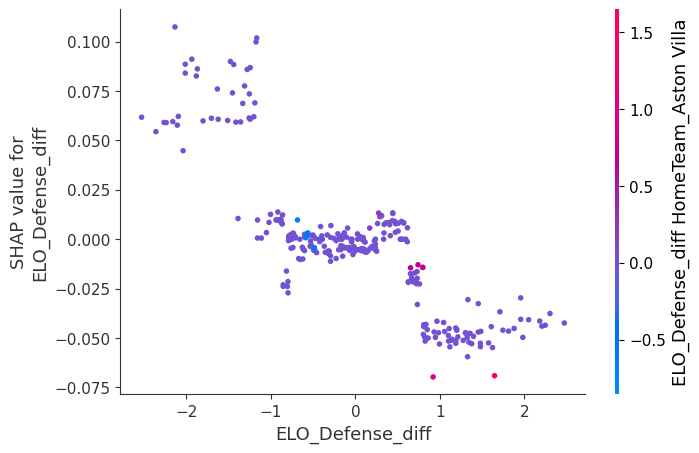

In [ ]:
shap.initjs()
shap.dependence_plot("ELO_Defense_diff", shap_values_gb[class_index], features=X_train_interacted, feature_names=interaction_feature_names)


SHAP Force Plot for Class: Away


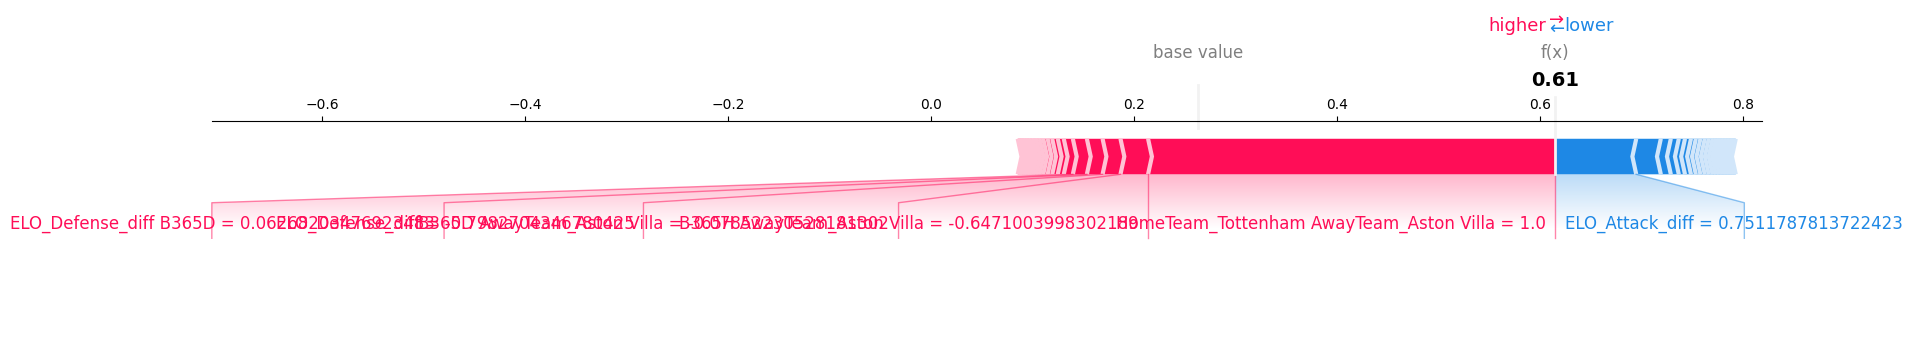

SHAP Force Plot for Class: Draw


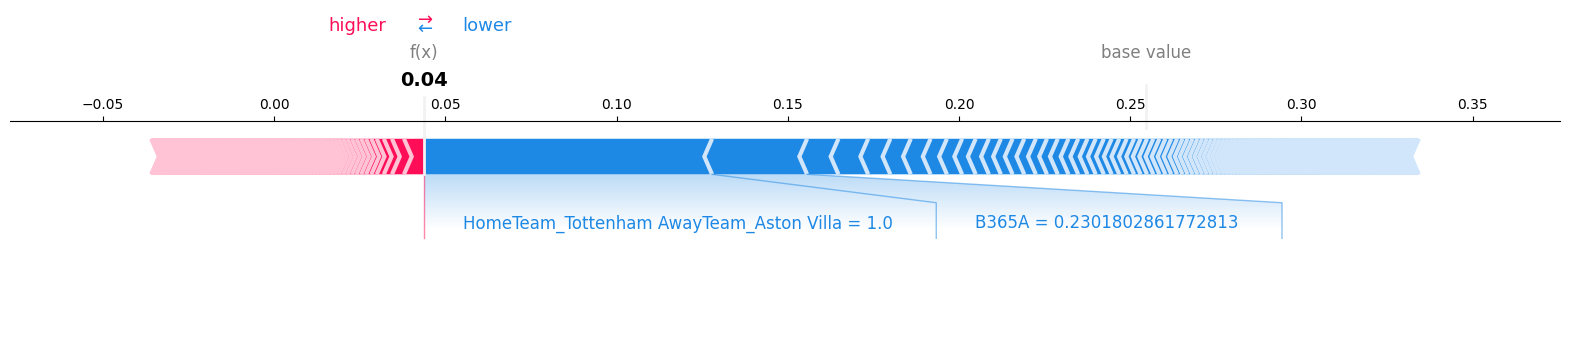

SHAP Force Plot for Class: Home


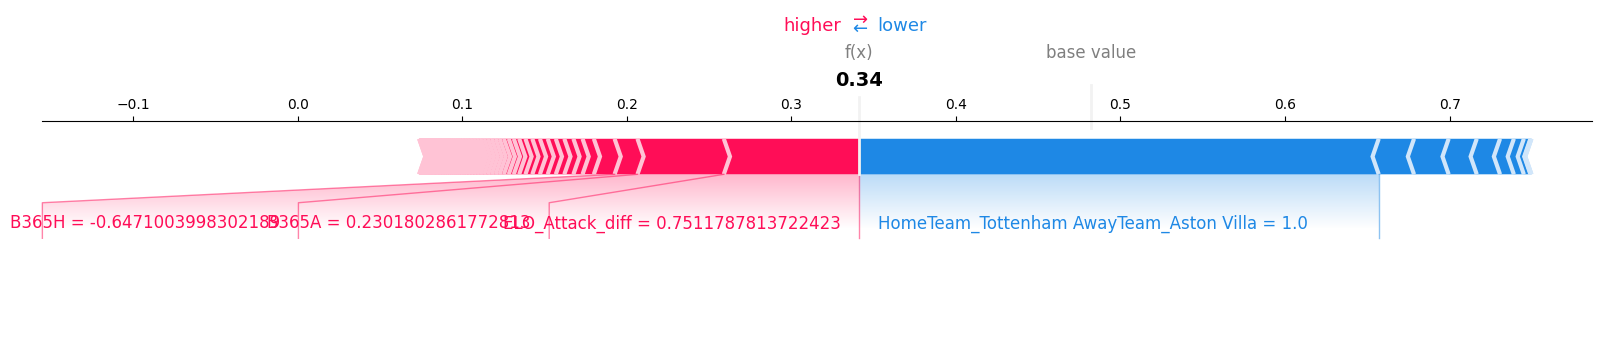

In [ ]:
import shap
shap.initjs()

# For each class, plot the SHAP values for a specific instance
for class_index, class_name in enumerate(result_encoder.categories_[0]):
    print(f"SHAP Force Plot for Class: {class_name}")
    shap.force_plot(
        base_value=explainer_gb.expected_value[class_index],
        shap_values=shap_values_gb[class_index][instance_index],
        features=X_train_interacted[instance_index],
        feature_names=interaction_feature_names,
        matplotlib=True
    )


SHAP Summary Plot for Class: Away


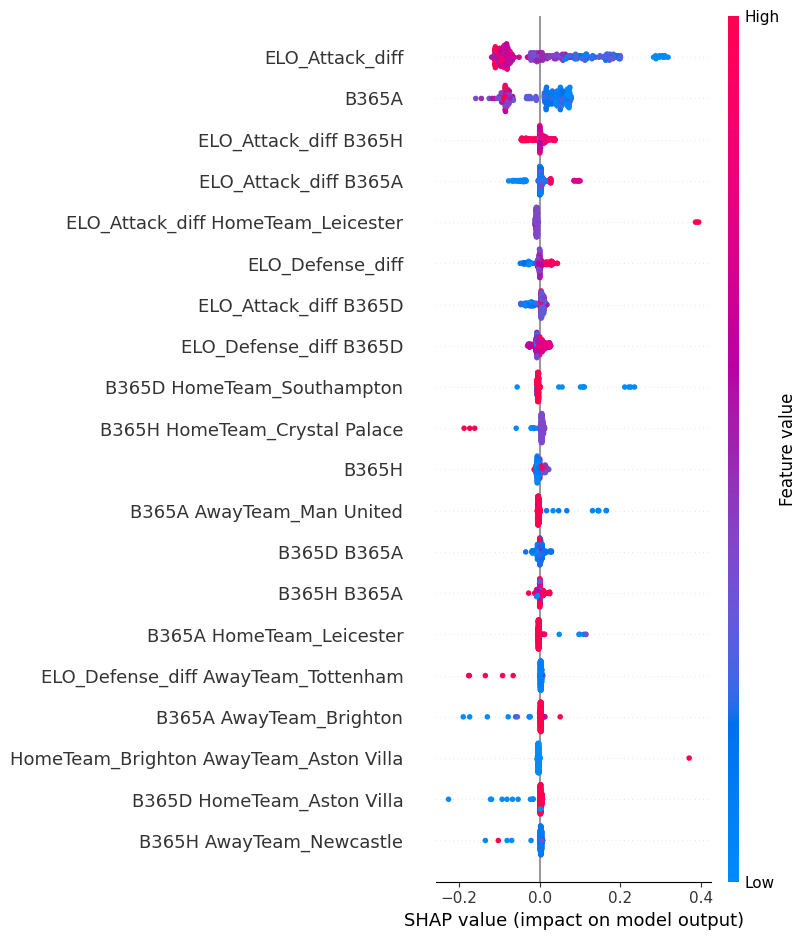

SHAP Summary Plot for Class: Draw


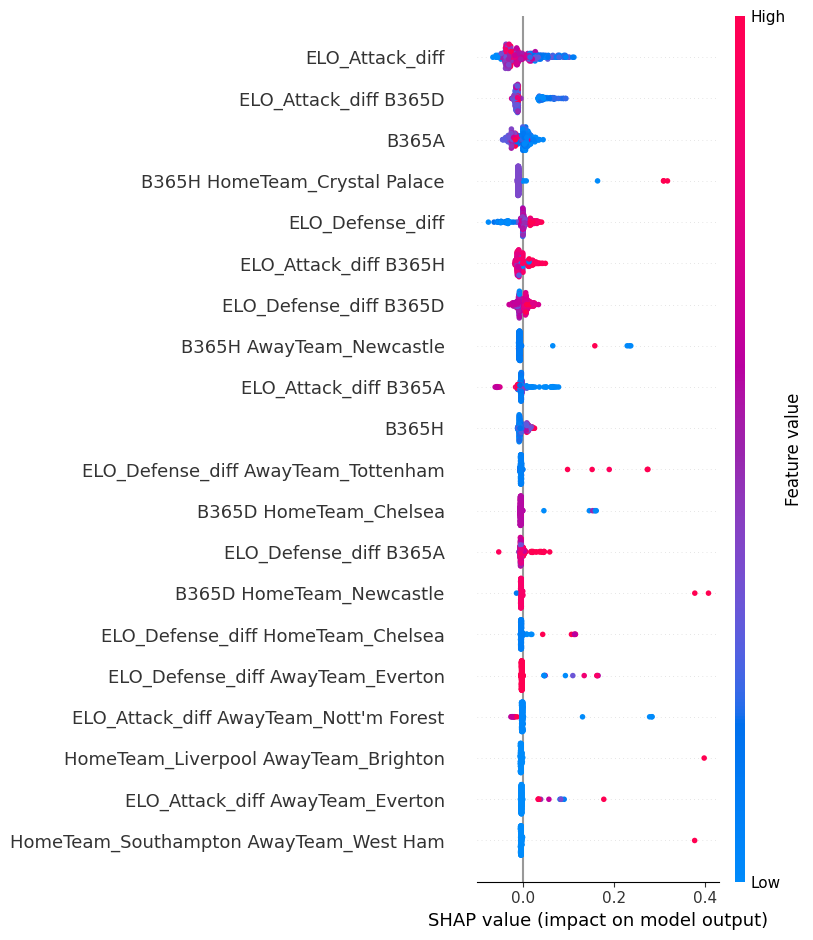

SHAP Summary Plot for Class: Home


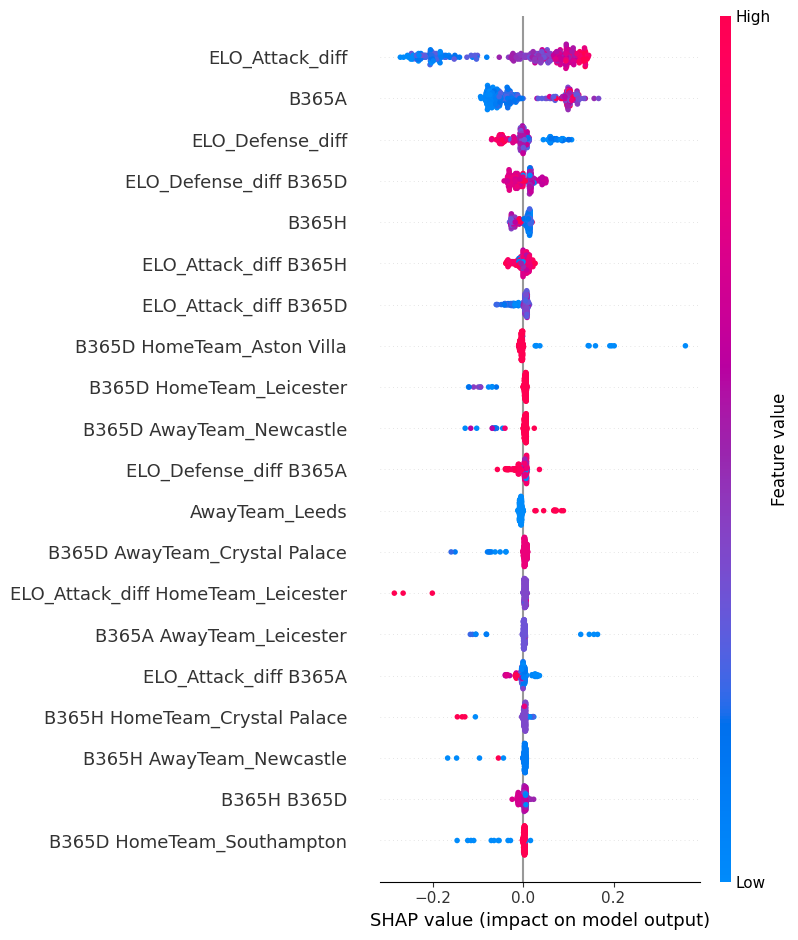

In [ ]:
import shap

# For each class, plot the SHAP Summary Plot
for class_index, class_name in enumerate(result_encoder.categories_[0]):
    print(f"SHAP Summary Plot for Class: {class_name}")
    shap.summary_plot(shap_values_gb[class_index], features=X_train_interacted, feature_names=interaction_feature_names)


In [ ]:
import pandas as pd

# Assume shap_values_gb is the SHAP values for Gradient Boosting model
# and interaction_feature_names is the list of feature names after interaction

# Save SHAP values for all classes into different sheets of the same Excel file
with pd.ExcelWriter("/content/shap_values_all_classes.xlsx", engine='openpyxl') as writer:
    for class_index, class_shap_values in enumerate(shap_values_gb):
        shap_df = pd.DataFrame(class_shap_values, columns=interaction_feature_names)
        shap_df.to_excel(writer, sheet_name=f'Class_{class_index}', index=False)

instance_shap_df = pd.DataFrame(instance_shap_values, columns=interaction_feature_names)
instance_shap_df.index = [f'Class_{i}' for i in range(len(instance_shap_values))]
instance_shap_df = instance_shap_df.transpose()  # Transposing the DataFrame to have classes as rows and features as columns
instance_shap_df.to_excel("/content/instance_shap_values.xlsx", index=True)



IndexError: ignored

In [ ]:
# Print the shapes of SHAP values for each class
for class_index, class_shap_values in enumerate(shap_values_gb):
    print(f"Class {class_index} SHAP values shape: {class_shap_values.shape}")

# Print the length of interaction_feature_names
print(f"Length of interaction_feature_names: {len(interaction_feature_names)}")


Class 0 SHAP values shape: (285, 1035)
Class 1 SHAP values shape: (285, 1035)
Class 2 SHAP values shape: (285, 1035)
Length of interaction_feature_names: 1035


In [ ]:
import pandas as pd

# Assuming shap_values_gb is a list of SHAP values for each class
# and interaction_feature_names is the list of feature names

# Creating an empty list to store DataFrames for each class
dfs = []

for class_index, class_shap_values in enumerate(shap_values_gb):
    # Converting SHAP values for each class to a DataFrame
    df = pd.DataFrame(class_shap_values, columns=interaction_feature_names)
    # Adding class index as the top level of columns MultiIndex
    df.columns = pd.MultiIndex.from_product([[f'Class_{class_index}'], interaction_feature_names], names=['Class', 'Feature'])
    dfs.append(df)

# Concatenating DataFrames horizontally
final_df = pd.concat(dfs, axis=1)

# Writing the DataFrame to an Excel file
final_df.to_excel("/content/shap_values_multiindex.xlsx")


NameError: ignored

In [ ]:
!pip install xlsxwriter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.5/153.5 kB 1.7 MB/s eta 0:00:00


In [ ]:
# For Logistic Regression
lr_model = base_models['Logistic Regression']
explainer_lr = shap.LinearExplainer(lr_model, X_train_interacted)
shap_values_lr = explainer_lr.shap_values(X_train_interacted)


In [ ]:
# Use a subset of the training data as the background dataset
rf_model = base_models['Random Forest']
background_data_rf = shap.sample(X_train_interacted, 100)  # Use 100 instances as background
explainer_gb_rf = shap.KernelExplainer(rf_model.predict_proba, background_data_rf)
shap_values_gb_rf = explainer_gb_rf.shap_values(X_train_interacted)

  0%|          | 0/285 [00:00<?, ?it/s]

In [ ]:
# Required imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import cross_val_predict
import random
import os
import warnings

np.random.seed(0)
tf.random.set_seed(0)
random.seed(0)

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.filterwarnings('ignore')

# Load the data
elo_ratings_vs_points = pd.read_csv("/content/elo_ratings_vs_points_3.csv")
combined_elo_ratings = pd.read_csv("/content/elo_ratings_3.csv")
combined_data = pd.read_csv("/content/E0.csv")

# Process 'Date' if it's a column in combined_data
if 'Date' in combined_data.columns:
    combined_data['Date'] = pd.to_datetime(combined_data['Date'])
    combined_data.sort_values(by='Date', inplace=True)
    combined_data.reset_index(drop=True, inplace=True)

# Map ELO ratings for home and away teams' attack and defense
combined_data['ELO_Attack_Home'] = combined_data['HomeTeam'].map(combined_elo_ratings.set_index('Team')['AttackELO'])
combined_data['ELO_Defense_Home'] = combined_data['HomeTeam'].map(combined_elo_ratings.set_index('Team')['DefenseELO'])
combined_data['ELO_Attack_Away'] = combined_data['AwayTeam'].map(combined_elo_ratings.set_index('Team')['AttackELO'])
combined_data['ELO_Defense_Away'] = combined_data['AwayTeam'].map(combined_elo_ratings.set_index('Team')['DefenseELO'])

# Calculate ELO differences for attack and defense
combined_data['ELO_Attack_diff'] = combined_data['ELO_Attack_Home'] - combined_data['ELO_Attack_Away']
combined_data['ELO_Defense_diff'] = combined_data['ELO_Defense_Home'] - combined_data['ELO_Defense_Away']

# Create target variable
conditions = [
    combined_data['FTHG'] > combined_data['FTAG'],
    combined_data['FTHG'] < combined_data['FTAG'],
    combined_data['FTHG'] == combined_data['FTAG']
]
choices = ['Home', 'Away', 'Draw']
combined_data['Result'] = np.select(conditions, choices)

# Include Betting Odds in the Training Data:
betting_odds_features = ['B365H', 'B365D', 'B365A']  # Modify as per your actual betting odds features

# Split data into train and test sets
X = combined_data[['ELO_Attack_diff', 'ELO_Defense_diff', 'HomeTeam', 'AwayTeam'] + betting_odds_features]
y = combined_data['Result']
combined_data['interaction_term_1'] = combined_data['B365H'] * combined_data['ELO_Attack_diff']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Normalize ELO differences and Betting Odds
scaler = StandardScaler()
X_train.loc[:, ['ELO_Attack_diff', 'ELO_Defense_diff'] + betting_odds_features] = scaler.fit_transform(X_train[['ELO_Attack_diff', 'ELO_Defense_diff'] + betting_odds_features])
X_test.loc[:, ['ELO_Attack_diff', 'ELO_Defense_diff'] + betting_odds_features] = scaler.transform(X_test[['ELO_Attack_diff', 'ELO_Defense_diff'] + betting_odds_features])

# Convert categorical columns to one-hot encoded format
team_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
team_encoder.fit(pd.concat([X_train[['HomeTeam', 'AwayTeam']], X_test[['HomeTeam', 'AwayTeam']]]))
X_train_encoded = team_encoder.transform(X_train[['HomeTeam', 'AwayTeam']])
X_test_encoded = team_encoder.transform(X_test[['HomeTeam', 'AwayTeam']])

# Drop the original categorical columns from X_train and X_test and concatenate the one-hot encoded columns with the remaining numerical columns
X_train = np.hstack((X_train.drop(['HomeTeam', 'AwayTeam'], axis=1).values, X_train_encoded))
X_test = np.hstack((X_test.drop(['HomeTeam', 'AwayTeam'], axis=1).values, X_test_encoded))

# Generate interaction features
interaction = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_interacted = interaction.fit_transform(X_train)
X_test_interacted = interaction.transform(X_test)

# Original feature names before interaction
feature_names_before_interaction = ['ELO_Attack_diff', 'ELO_Defense_diff', 'B365H', 'B365D', 'B365A']

# Getting one-hot-encoded feature names for 'HomeTeam' and 'AwayTeam' and adding them to feature_names_before_interaction
home_team_feature_names = [f"HomeTeam_{category}" for category in team_encoder.categories_[0]]
away_team_feature_names = [f"AwayTeam_{category}" for category in team_encoder.categories_[1]]

# Adding one-hot-encoded feature names to feature_names_before_interaction
feature_names_before_interaction.extend(home_team_feature_names)
feature_names_before_interaction.extend(away_team_feature_names)

# Get the feature names after interaction
interaction_feature_names = interaction.get_feature_names_out(input_features=feature_names_before_interaction)

# Assume importances is the array of feature importances from your model.
# Replace rf_model with the actual model you are using for predictions.
importances = rf_model.feature_importances_

# Map importances to feature names
feature_importances_df = pd.DataFrame({"Feature": interaction_feature_names, "Importance": importances})
feature_importances_df.sort_values(by="Importance", ascending=False, inplace=True)

# Filter to see importance of betting odds and their interactions
odds_importance_df = feature_importances_df[feature_importances_df['Feature'].str.contains('B365H|B365D|B365A')]

# Display or further analyze odds_importance_df to understand the importance of odds and their interactions
print(odds_importance_df)

# Specify the path where you want to save the file
file_path_feature_names_before_interaction = "/content/feature_importances2.xlsx"

# Save the DataFrame to an Excel file
feature_importances_df.to_excel(file_path_feature_names_before_interaction, index=False)

# Convert target variable to one-hot encoded format
result_encoder = OneHotEncoder(sparse=False)
y_train_encoded = result_encoder.fit_transform(y_train.values.reshape(-1, 1))
y_test_encoded = result_encoder.transform(y_test.values.reshape(-1, 1))

# Apply SMOTE for balancing classes
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_interacted, y_train)

# Convert y_train_smote to one-hot encoded format
y_train_smote_encoded = result_encoder.transform(y_train_smote.values.reshape(-1, 1))

# Define and compile the Neural Network model
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_interacted.shape[1],)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])
nn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train and evaluate the Neural Network model with SMOTE resampled data
nn_model.fit(X_train_smote, y_train_smote_encoded, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
train_accuracy_nn = nn_model.evaluate(X_train_smote, y_train_smote_encoded)[1]
test_accuracy_nn = nn_model.evaluate(X_test_interacted, y_test_encoded)[1]

# Adjusting RandomForest Model based on insights
from sklearn.model_selection import GridSearchCV

rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestClassifier(random_state=42)
rf_grid_search = GridSearchCV(rf, rf_param_grid, cv=5, scoring='accuracy')
rf_grid_search.fit(X_train_interacted, y_train)

# Use the best estimator for RandomForest
best_rf_model = rf_grid_search.best_estimator_
base_models['Random Forest'] = best_rf_model  # Update the RandomForest model in base_models dictionary

# Base models for cross-validation predictions
base_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

# Train the base models on the training data
for name, base_model in base_models.items():
    base_model.fit(X_train_interacted, y_train)

# Insert the feature importance extraction code here
# Extract Feature Importances from the Random Forest Model
rf_model = base_models['Random Forest']  # Getting the trained Random Forest model from your base models dictionary

# Extract Feature Importances
importances = rf_model.feature_importances_

# Get the feature names before one-hot encoding and interaction term generation
feature_names = ['ELO_Attack_diff', 'ELO_Defense_diff'] + betting_odds_features

# Get the one-hot encoded feature names
feature_names += list(team_encoder.get_feature_names_out(['HomeTeam', 'AwayTeam']))

# Get the interaction term feature names
#interaction_feature_names = interaction.get_feature_names_out(input_features=feature_names)

# Create a DataFrame with feature importances
#feature_importances_df = pd.DataFrame({'Feature': interaction_feature_names, 'Importance': importances})

# Sort the DataFrame by the importances
#feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
#print(feature_importances_df)

# Specify the path where you want to save the file
#file_path_feature_importance = "/content/feature_importances.xlsx"

# Save the DataFrame to an Excel file
#feature_importances_df.to_excel(file_path_feature_importance, index=False)

interaction_feature_names = interaction.get_feature_names_out()
feature_importances_df = pd.DataFrame(index=interaction_feature_names)
for name, model in base_models.items():
    if hasattr(model, 'feature_importances_'):
        feature_importances_df[name] = model.feature_importances_
    elif hasattr(model, 'coef_'):
        feature_importances_df[name] = model.coef_[0]
    else:
        feature_importances_df[name] = None
feature_importances_df.to_excel('/content/feature_importances3.xlsx')



# Generate meta-features using cross-validation
X_train_meta_cv = np.hstack([cross_val_predict(base_model, X_train_interacted, y_train, method="predict_proba", cv=5)
                             for name, base_model in base_models.items()])

# Generate meta-features for the test set using trained base models
X_test_meta = np.hstack([base_model.predict_proba(X_test_interacted) for name, base_model in base_models.items()])

# Define a function to create and train a model based on hyperparameters
def train_meta_model(params):
    meta_model = Sequential([
        Dense(params['neurons'], activation='relu', input_shape=(X_train_meta_cv.shape[1],)),
        Dropout(params['dropout_rate']),
        Dense(int(params['neurons']/2), activation='relu'),
        Dropout(params['dropout_rate']),
        Dense(3, activation='softmax')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
    meta_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    history = meta_model.fit(X_train_meta_cv, y_train_encoded, epochs=params['epochs'],
                        batch_size=params['batch_size'], validation_split=0.2, verbose=0)
    val_acc = max(history.history['val_accuracy'])
    return val_acc, meta_model

# Define a grid of hyperparameters
param_grid = {
    'epochs': [10, 20, 30, 50],
    'batch_size': [16, 32, 64],
    'learning_rate': [0.001, 0.01, 0.1],
    'dropout_rate': [0.3, 0.5, 0.7],
    'neurons': [32, 64, 128]
}

# Randomly sample hyperparameter sets and train models
best_val_acc = 0
best_params = None
best_meta_model = None

for _ in range(10):  # for 10 iterations
    params = {k: random.choice(v) for k, v in param_grid.items()}
    val_acc, meta_model = train_meta_model(params)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_params = params
        best_meta_model = meta_model

# Train the best meta model on the entire training set
best_meta_model.fit(X_train_meta_cv, y_train_encoded, epochs=best_params['epochs'],
                  batch_size=best_params['batch_size'], verbose=0)

# Evaluate the meta model on the test set
test_accuracy_optimal = best_meta_model.evaluate(X_test_meta, y_test_encoded)[1]
print(f"Test Accuracy with Optimal Hyperparameters: {test_accuracy_optimal:.2f}")

def predict_outcome_corrected(team_home, team_away, best_meta_model, scaler, interaction,
                              result_encoder, combined_elo_ratings, base_models, betting_odds):
    # Retrieve ELO ratings for the two teams
    elo_attack_home = combined_elo_ratings.loc[combined_elo_ratings['Team'] == team_home, 'AttackELO'].values[0]
    elo_defense_home = combined_elo_ratings.loc[combined_elo_ratings['Team'] == team_home, 'DefenseELO'].values[0]
    elo_attack_away = combined_elo_ratings.loc[combined_elo_ratings['Team'] == team_away, 'AttackELO'].values[0]
    elo_defense_away = combined_elo_ratings.loc[combined_elo_ratings['Team'] == team_away, 'DefenseELO'].values[0]

    # Calculate ELO differences
    elo_attack_diff = elo_attack_home - elo_attack_away
    elo_defense_diff = elo_defense_home - elo_defense_away

    # Normalize ELO differences and Betting Odds
    elo_diff_normalized = scaler.transform([[elo_attack_diff, elo_defense_diff] + [betting_odds[feature] for feature in betting_odds_features]])

    # One-hot encode the teams
    teams_encoded = team_encoder.transform([[team_home, team_away]])

    # Concatenate the normalized elo differences with the one-hot encoded teams
    data = np.hstack((elo_diff_normalized, teams_encoded))

    # Create interaction features
    data_interacted = interaction.transform(data)

    # Generate meta-features using trained base models
    data_meta = np.hstack([base_model.predict_proba(data_interacted) for name, base_model in base_models.items()])

    # Check if the shape of data_meta is as expected
    expected_features = 9  # Change this to the actual number of expected features based on your meta model architecture
    if data_meta.shape[1] != expected_features:
        raise ValueError(f"Unexpected shape of data_meta: {data_meta.shape}. Expected second dimension to be {expected_features}.")

    # Make a prediction using the trained meta model
    prediction_probabilities = best_meta_model.predict(data_meta)
    predicted_class = result_encoder.inverse_transform(prediction_probabilities)

    return predicted_class[0][0]


                       Feature  Importance
4                        B365A    0.035304
2                        B365H    0.034230
46       ELO_Attack_diff B365H    0.027074
89      ELO_Defense_diff B365H    0.023540
91      ELO_Defense_diff B365A    0.021738
..                         ...         ...
186   B365D HomeTeam_Liverpool    0.001190
183      B365D HomeTeam_Fulham    0.001105
226   B365A HomeTeam_Liverpool    0.001000
146    B365H HomeTeam_Man City    0.000880
228  B365A HomeTeam_Man United    0.000879

[132 rows x 2 columns]
3/3 [==============================] - 0s 5ms/step - loss: 1.0472 - accuracy: 0.4842
Test Accuracy with Optimal Hyperparameters: 0.48


In [ ]:
import pandas as pd

def predict_outcome_corrected(team_home, team_away, best_meta_model, scaler, interaction,
                              result_encoder, combined_elo_ratings, base_models, betting_odds):
    # Retrieve ELO ratings for the two teams
    elo_attack_home = combined_elo_ratings.loc[combined_elo_ratings['Team'] == team_home, 'AttackELO'].values[0]
    elo_defense_home = combined_elo_ratings.loc[combined_elo_ratings['Team'] == team_home, 'DefenseELO'].values[0]
    elo_attack_away = combined_elo_ratings.loc[combined_elo_ratings['Team'] == team_away, 'AttackELO'].values[0]
    elo_defense_away = combined_elo_ratings.loc[combined_elo_ratings['Team'] == team_away, 'DefenseELO'].values[0]

    print(f"ELO Attack Home: {elo_attack_home}, ELO Defense Home: {elo_defense_home}, ELO Attack Away: {elo_attack_away}, ELO Defense Away: {elo_defense_away}")

    # Calculate ELO differences
    elo_attack_diff = elo_attack_home - elo_attack_away
    elo_defense_diff = elo_defense_home - elo_defense_away

    print(f"ELO Attack Diff: {elo_attack_diff}, ELO Defense Diff: {elo_defense_diff}")

    # Normalize ELO differences and Betting Odds
    elo_diff_normalized = scaler.transform([[elo_attack_diff, elo_defense_diff] + [betting_odds[feature] for feature in betting_odds_features]])

    # Save Normalized ELO differences and Betting Odds to Excel
    normalized_df = pd.DataFrame(elo_diff_normalized, columns=['ELO_Attack_diff', 'ELO_Defense_diff'] + betting_odds_features)
    normalized_df.to_excel("/content/elo_diff_normalized.xlsx", index=False)

    # One-hot encode the teams
    teams_encoded = team_encoder.transform([[team_home, team_away]])

    # Concatenate the normalized elo differences with the one-hot encoded teams
    data = np.hstack((elo_diff_normalized, teams_encoded))

    # Create interaction features
    data_interacted = interaction.transform(data)

    # Save Interacted data to Excel
    interaction_feature_names = interaction.get_feature_names_out()  # Assuming interaction is the PolynomialFeatures object
    interacted_df = pd.DataFrame(data_interacted, columns=interaction_feature_names)
    interacted_df.to_excel("/content/data_interacted.xlsx", index=False)

    # Generate meta-features using trained base models
    data_meta = np.hstack([base_model.predict_proba(data_interacted) for name, base_model in base_models.items()])

    # Save Meta data to Excel
    meta_feature_names = [
    "LogisticRegression_Home", "LogisticRegression_Draw", "LogisticRegression_Away",
    "RandomForest_Home", "RandomForest_Draw", "RandomForest_Away",
    "GradientBoosting_Home", "GradientBoosting_Draw", "GradientBoosting_Away"
    ] # Make sure this list contains the correct names of the meta features
    meta_df = pd.DataFrame(data_meta, columns=meta_feature_names)
    meta_df.to_excel("/content/data_meta.xlsx", index=False)

    # Check if the shape of data_meta is as expected
    expected_features = 9  # Change this to the actual number of expected features based on your meta model architecture
    if data_meta.shape[1] != expected_features:
        raise ValueError(f"Unexpected shape of data_meta: {data_meta.shape}. Expected second dimension to be {expected_features}.")

    # Make a prediction using the trained meta model
    prediction_probabilities = best_meta_model.predict(data_meta)
    predicted_class = result_encoder.inverse_transform(prediction_probabilities)

    return predicted_class[0][0]



In [ ]:
# Example Usage of Prediction Function with optimized models
team_home = "Chelsea"
team_away = "Liverpool"
betting_odds = {"B365H": 100.0, "B365D": 7.5, "B365A": 0.01}

print("Predicted Outcome: ", predict_outcome_corrected(
    team_home, team_away, best_meta_model, scaler, interaction, result_encoder,
    combined_elo_ratings, base_models, betting_odds
))


ELO Attack Home: 1593.1678304003049, ELO Defense Home: 372.4294828496783, ELO Attack Away: 2748.217284883959, ELO Defense Away: -836.4906536144402
ELO Attack Diff: -1155.0494544836542, ELO Defense Diff: 1208.9201364641185
1/1 [==============================] - 0s 53ms/step
Predicted Outcome:  Home


In [ ]:
import pandas as pd

def predict_outcome_corrected(team_home, team_away, best_meta_model, scaler, interaction,
                              result_encoder, combined_elo_ratings, base_models, betting_odds):
    # Retrieve ELO ratings for the two teams
    elo_attack_home = combined_elo_ratings.loc[combined_elo_ratings['Team'] == team_home, 'AttackELO'].values[0]
    elo_defense_home = combined_elo_ratings.loc[combined_elo_ratings['Team'] == team_home, 'DefenseELO'].values[0]
    elo_attack_away = combined_elo_ratings.loc[combined_elo_ratings['Team'] == team_away, 'AttackELO'].values[0]
    elo_defense_away = combined_elo_ratings.loc[combined_elo_ratings['Team'] == team_away, 'DefenseELO'].values[0]

    print(f"ELO Attack Home: {elo_attack_home}, ELO Defense Home: {elo_defense_home}, ELO Attack Away: {elo_attack_away}, ELO Defense Away: {elo_defense_away}")

    # Calculate ELO differences
    elo_attack_diff = elo_attack_home - elo_attack_away
    elo_defense_diff = elo_defense_home - elo_defense_away

    print(f"ELO Attack Diff: {elo_attack_diff}, ELO Defense Diff: {elo_defense_diff}")

    # Normalize ELO differences and Betting Odds
    elo_diff_normalized = scaler.transform([[elo_attack_diff, elo_defense_diff] + [betting_odds[feature] for feature in betting_odds_features]])

    # Print original and normalized betting odds
    print("Original Betting Odds:", betting_odds)
    print("Normalized Betting Odds:", elo_diff_normalized[0][2:])  # Assuming betting odds are the last three features after normalization

    # Save Normalized ELO differences and Betting Odds to Excel
    normalized_df = pd.DataFrame(elo_diff_normalized, columns=['ELO_Attack_diff', 'ELO_Defense_diff'] + betting_odds_features)
    normalized_df.to_excel("/content/elo_diff_normalized.xlsx", index=False)

    # One-hot encode the teams
    teams_encoded = team_encoder.transform([[team_home, team_away]])

    # Concatenate the normalized elo differences with the one-hot encoded teams
    data = np.hstack((elo_diff_normalized, teams_encoded))

    # Create interaction features
    data_interacted = interaction.transform(data)

    # Save Interacted data to Excel
    interaction_feature_names = interaction.get_feature_names_out()  # Assuming interaction is the PolynomialFeatures object
    interacted_df = pd.DataFrame(data_interacted, columns=interaction_feature_names)
    interacted_df.to_excel("/content/data_interacted.xlsx", index=False)

    # Generate meta-features using trained base models
    data_meta = np.hstack([base_model.predict_proba(data_interacted) for name, base_model in base_models.items()])

    # Save Meta data to Excel
    meta_feature_names = [
        "LogisticRegression_Home", "LogisticRegression_Draw", "LogisticRegression_Away",
        "RandomForest_Home", "RandomForest_Draw", "RandomForest_Away",
        "GradientBoosting_Home", "GradientBoosting_Draw", "GradientBoosting_Away"
    ]  # Make sure this list contains the correct names of the meta features
    meta_df = pd.DataFrame(data_meta, columns=meta_feature_names)
    meta_df.to_excel("/content/data_meta.xlsx", index=False)

    # Check if the shape of data_meta is as expected
    expected_features = 9  # Change this to the actual number of expected features based on your meta model architecture
    if data_meta.shape[1] != expected_features:
        raise ValueError(f"Unexpected shape of data_meta: {data_meta.shape}. Expected second dimension to be {expected_features}.")

    # Print the contribution of each feature to the models' decisions
    for name, base_model in base_models.items():
        if hasattr(base_model, 'feature_importances_'):
            print(f"Feature Importances in {name}:", base_model.feature_importances_)

    # Make a prediction using the trained meta model
    prediction_probabilities = best_meta_model.predict(data_meta)
    predicted_class = result_encoder.inverse_transform(prediction_probabilities)

    return predicted_class[0][0]


In [ ]:
# Example Usage of Prediction Function with optimized models
team_home = "Chelsea"
team_away = "Liverpool"
betting_odds = {"B365H": 100.0, "B365D": 7.5, "B365A": 0.01}

print("Predicted Outcome: ", predict_outcome_corrected(
    team_home, team_away, best_meta_model, scaler, interaction, result_encoder,
    combined_elo_ratings, base_models, betting_odds
))


ELO Attack Home: 1593.1678304003049, ELO Defense Home: 372.4294828496783, ELO Attack Away: 2748.217284883959, ELO Defense Away: -836.4906536144402
ELO Attack Diff: -1155.0494544836542, ELO Defense Diff: 1208.9201364641185
Original Betting Odds: {'B365H': 100.0, 'B365D': 7.5, 'B365A': 0.01}
Normalized Betting Odds: [53.11305008  2.91101966 -1.21597139]
Feature Importances in Random Forest: [0.03188082 0.02890011 0.03423019 ... 0.         0.         0.        ]
Feature Importances in Gradient Boosting: [0.12126146 0.0142337  0.0108481  ... 0.         0.         0.        ]
1/1 [==============================] - 0s 15ms/step
Predicted Outcome:  Home


TEST BELOW

In [ ]:
# Required imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import cross_val_predict
import random
import os
import warnings

np.random.seed(0)
tf.random.set_seed(0)
random.seed(0)

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.filterwarnings('ignore')

# Load the data
elo_ratings_vs_points = pd.read_csv("/content/elo_ratings_vs_points_3.csv")
combined_elo_ratings = pd.read_csv("/content/elo_ratings_3.csv")
combined_data = pd.read_csv("/content/E0.csv")

# Process 'Date' if it's a column in combined_data
if 'Date' in combined_data.columns:
    combined_data['Date'] = pd.to_datetime(combined_data['Date'])
    combined_data.sort_values(by='Date', inplace=True)
    combined_data.reset_index(drop=True, inplace=True)

# Map ELO ratings for home and away teams' attack and defense
combined_data['ELO_Attack_Home'] = combined_data['HomeTeam'].map(combined_elo_ratings.set_index('Team')['AttackELO'])
combined_data['ELO_Defense_Home'] = combined_data['HomeTeam'].map(combined_elo_ratings.set_index('Team')['DefenseELO'])
combined_data['ELO_Attack_Away'] = combined_data['AwayTeam'].map(combined_elo_ratings.set_index('Team')['AttackELO'])
combined_data['ELO_Defense_Away'] = combined_data['AwayTeam'].map(combined_elo_ratings.set_index('Team')['DefenseELO'])

# Calculate ELO differences for attack and defense
combined_data['ELO_Attack_diff'] = combined_data['ELO_Attack_Home'] - combined_data['ELO_Attack_Away']
combined_data['ELO_Defense_diff'] = combined_data['ELO_Defense_Home'] - combined_data['ELO_Defense_Away']

# Create target variable
conditions = [
    combined_data['FTHG'] > combined_data['FTAG'],
    combined_data['FTHG'] < combined_data['FTAG'],
    combined_data['FTHG'] == combined_data['FTAG']
]
choices = ['Home', 'Away', 'Draw']
combined_data['Result'] = np.select(conditions, choices)

# Include Betting Odds in the Training Data:
betting_odds_features = ['B365H', 'B365D', 'B365A']  # Modify as per your actual betting odds features
# Feature Engineering: Log transformation of odds
combined_data['log_B365H'] = np.log(combined_data['B365H'])

# Split data into train and test sets
X = combined_data[['ELO_Attack_diff', 'ELO_Defense_diff', 'HomeTeam', 'AwayTeam'] + betting_odds_features]
y = combined_data['Result']
combined_data['interaction_term_1'] = combined_data['B365H'] * combined_data['ELO_Attack_diff']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Normalize ELO differences and Betting Odds
scaler = StandardScaler()
X_train.loc[:, ['ELO_Attack_diff', 'ELO_Defense_diff'] + betting_odds_features] = scaler.fit_transform(X_train[['ELO_Attack_diff', 'ELO_Defense_diff'] + betting_odds_features])
X_test.loc[:, ['ELO_Attack_diff', 'ELO_Defense_diff'] + betting_odds_features] = scaler.transform(X_test[['ELO_Attack_diff', 'ELO_Defense_diff'] + betting_odds_features])

# Convert categorical columns to one-hot encoded format
team_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
team_encoder.fit(pd.concat([X_train[['HomeTeam', 'AwayTeam']], X_test[['HomeTeam', 'AwayTeam']]]))
X_train_encoded = team_encoder.transform(X_train[['HomeTeam', 'AwayTeam']])
X_test_encoded = team_encoder.transform(X_test[['HomeTeam', 'AwayTeam']])

# Drop the original categorical columns from X_train and X_test and concatenate the one-hot encoded columns with the remaining numerical columns
X_train = np.hstack((X_train.drop(['HomeTeam', 'AwayTeam'], axis=1).values, X_train_encoded))
X_test = np.hstack((X_test.drop(['HomeTeam', 'AwayTeam'], axis=1).values, X_test_encoded))

# Generate interaction features
interaction = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_interacted = interaction.fit_transform(X_train)
X_test_interacted = interaction.transform(X_test)

# Original feature names before interaction
feature_names_before_interaction = ['ELO_Attack_diff', 'ELO_Defense_diff', 'B365H', 'B365D', 'B365A']

# Getting one-hot-encoded feature names for 'HomeTeam' and 'AwayTeam' and adding them to feature_names_before_interaction
home_team_feature_names = [f"HomeTeam_{category}" for category in team_encoder.categories_[0]]
away_team_feature_names = [f"AwayTeam_{category}" for category in team_encoder.categories_[1]]

# Adding one-hot-encoded feature names to feature_names_before_interaction
feature_names_before_interaction.extend(home_team_feature_names)
feature_names_before_interaction.extend(away_team_feature_names)

# Get the feature names after interaction
interaction_feature_names = interaction.get_feature_names_out(input_features=feature_names_before_interaction)

# Assume importances is the array of feature importances from your model.
# Replace rf_model with the actual model you are using for predictions.
importances = rf_model.feature_importances_

# Map importances to feature names
feature_importances_df = pd.DataFrame({"Feature": interaction_feature_names, "Importance": importances})
feature_importances_df.sort_values(by="Importance", ascending=False, inplace=True)

# Filter to see importance of betting odds and their interactions
odds_importance_df = feature_importances_df[feature_importances_df['Feature'].str.contains('B365H|B365D|B365A')]

# Display or further analyze odds_importance_df to understand the importance of odds and their interactions
print(odds_importance_df)

# Specify the path where you want to save the file
file_path_feature_names_before_interaction = "/content/feature_importances2.xlsx"

# Save the DataFrame to an Excel file
feature_importances_df.to_excel(file_path_feature_names_before_interaction, index=False)

# Convert target variable to one-hot encoded format
result_encoder = OneHotEncoder(sparse=False)
y_train_encoded = result_encoder.fit_transform(y_train.values.reshape(-1, 1))
y_test_encoded = result_encoder.transform(y_test.values.reshape(-1, 1))

# Apply SMOTE for balancing classes
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_interacted, y_train)

# Convert y_train_smote to one-hot encoded format
y_train_smote_encoded = result_encoder.transform(y_train_smote.values.reshape(-1, 1))

# Define and compile the Neural Network model
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_interacted.shape[1],)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])
nn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train and evaluate the Neural Network model with SMOTE resampled data
nn_model.fit(X_train_smote, y_train_smote_encoded, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
train_accuracy_nn = nn_model.evaluate(X_train_smote, y_train_smote_encoded)[1]
test_accuracy_nn = nn_model.evaluate(X_test_interacted, y_test_encoded)[1]

# Adjusting RandomForest Model based on insights
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter Tuning with Randomized Search CV
param_dist_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestClassifier(random_state=42)
random_search_rf = RandomizedSearchCV(rf, param_distributions=param_dist_rf, n_iter=100, cv=5, verbose=1, n_jobs=-1)
random_search_rf.fit(X_train_interacted, y_train)

# Using the Best Estimator for Random Forest
best_rf_model = random_search_rf.best_estimator_
base_models['Random Forest'] = best_rf_model  # Update the RandomForest model in base_models dictionary

# Base models for cross-validation predictions
base_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

# Train the base models on the training data
for name, base_model in base_models.items():
    base_model.fit(X_train_interacted, y_train)

# Insert the feature importance extraction code here
# Extract Feature Importances from the Random Forest Model
rf_model = base_models['Random Forest']  # Getting the trained Random Forest model from your base models dictionary

# Extract Feature Importances
importances = rf_model.feature_importances_

# Get the feature names before one-hot encoding and interaction term generation
feature_names = ['ELO_Attack_diff', 'ELO_Defense_diff'] + betting_odds_features

# Get the one-hot encoded feature names
feature_names += list(team_encoder.get_feature_names_out(['HomeTeam', 'AwayTeam']))

# Get the interaction term feature names
#interaction_feature_names = interaction.get_feature_names_out(input_features=feature_names)

# Create a DataFrame with feature importances
#feature_importances_df = pd.DataFrame({'Feature': interaction_feature_names, 'Importance': importances})

# Sort the DataFrame by the importances
#feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
#print(feature_importances_df)

# Specify the path where you want to save the file
#file_path_feature_importance = "/content/feature_importances.xlsx"

# Save the DataFrame to an Excel file
#feature_importances_df.to_excel(file_path_feature_importance, index=False)

interaction_feature_names = interaction.get_feature_names_out()
feature_importances_df = pd.DataFrame(index=interaction_feature_names)
for name, model in base_models.items():
    if hasattr(model, 'feature_importances_'):
        feature_importances_df[name] = model.feature_importances_
    elif hasattr(model, 'coef_'):
        feature_importances_df[name] = model.coef_[0]
    else:
        feature_importances_df[name] = None
feature_importances_df.to_excel('/content/feature_importances3.xlsx')



# Generate meta-features using cross-validation
X_train_meta_cv = np.hstack([cross_val_predict(base_model, X_train_interacted, y_train, method="predict_proba", cv=5)
                             for name, base_model in base_models.items()])

# Generate meta-features for the test set using trained base models
X_test_meta = np.hstack([base_model.predict_proba(X_test_interacted) for name, base_model in base_models.items()])

# Define a function to create and train a model based on hyperparameters
def train_meta_model(params):
    meta_model = Sequential([
        Dense(params['neurons'], activation='relu', input_shape=(X_train_meta_cv.shape[1],)),
        Dropout(params['dropout_rate']),
        Dense(int(params['neurons']/2), activation='relu'),
        Dropout(params['dropout_rate']),
        Dense(3, activation='softmax')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
    meta_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    history = meta_model.fit(X_train_meta_cv, y_train_encoded, epochs=params['epochs'],
                        batch_size=params['batch_size'], validation_split=0.2, verbose=0)
    val_acc = max(history.history['val_accuracy'])
    return val_acc, meta_model

# Define a grid of hyperparameters
param_grid = {
    'epochs': [10, 20, 30, 50],
    'batch_size': [16, 32, 64],
    'learning_rate': [0.001, 0.01, 0.1],
    'dropout_rate': [0.3, 0.5, 0.7],
    'neurons': [32, 64, 128]
}

# Randomly sample hyperparameter sets and train models
best_val_acc = 0
best_params = None
best_meta_model = None

for _ in range(10):  # for 10 iterations
    params = {k: random.choice(v) for k, v in param_grid.items()}
    val_acc, meta_model = train_meta_model(params)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_params = params
        best_meta_model = meta_model

# Train the best meta model on the entire training set
best_meta_model.fit(X_train_meta_cv, y_train_encoded, epochs=best_params['epochs'],
                  batch_size=best_params['batch_size'], verbose=0)

# Evaluate the meta model on the test set
test_accuracy_optimal = best_meta_model.evaluate(X_test_meta, y_test_encoded)[1]
print(f"Test Accuracy with Optimal Hyperparameters: {test_accuracy_optimal:.2f}")

# Adjusting Custom Threshold if Necessary
threshold = 0.6  # Example, adjust it according to the specific use case
predicted_proba = best_meta_model.predict(X_test_meta)  # Use predict as it is a Neural Network

# If you are dealing with binary classification
# predicted_class = (predicted_proba[:,1] >= threshold).astype('int')  # Assuming class 1 is the positive class

# If you are dealing with multi-class classification, you might want to do something like this:
predicted_class = np.argmax(predicted_proba, axis=1)  # This will give you the index of the class with the highest probability


import pandas as pd

def predict_outcome_corrected(team_home, team_away, best_meta_model, scaler, interaction,
                              result_encoder, combined_elo_ratings, base_models, betting_odds):
    # Retrieve ELO ratings for the two teams
    elo_attack_home = combined_elo_ratings.loc[combined_elo_ratings['Team'] == team_home, 'AttackELO'].values[0]
    elo_defense_home = combined_elo_ratings.loc[combined_elo_ratings['Team'] == team_home, 'DefenseELO'].values[0]
    elo_attack_away = combined_elo_ratings.loc[combined_elo_ratings['Team'] == team_away, 'AttackELO'].values[0]
    elo_defense_away = combined_elo_ratings.loc[combined_elo_ratings['Team'] == team_away, 'DefenseELO'].values[0]

    print(f"ELO Attack Home: {elo_attack_home}, ELO Defense Home: {elo_defense_home}, ELO Attack Away: {elo_attack_away}, ELO Defense Away: {elo_defense_away}")

    # Calculate ELO differences
    elo_attack_diff = elo_attack_home - elo_attack_away
    elo_defense_diff = elo_defense_home - elo_defense_away

    print(f"ELO Attack Diff: {elo_attack_diff}, ELO Defense Diff: {elo_defense_diff}")

    # Normalize ELO differences and Betting Odds
    elo_diff_normalized = scaler.transform([[elo_attack_diff, elo_defense_diff] + [betting_odds[feature] for feature in betting_odds_features]])

    # Print original and normalized betting odds
    print("Original Betting Odds:", betting_odds)
    print("Normalized Betting Odds:", elo_diff_normalized[0][2:])  # Assuming betting odds are the last three features after normalization

    # Save Normalized ELO differences and Betting Odds to Excel
    normalized_df = pd.DataFrame(elo_diff_normalized, columns=['ELO_Attack_diff', 'ELO_Defense_diff'] + betting_odds_features)
    normalized_df.to_excel("/content/elo_diff_normalized.xlsx", index=False)

    # One-hot encode the teams
    teams_encoded = team_encoder.transform([[team_home, team_away]])

    # Concatenate the normalized elo differences with the one-hot encoded teams
    data = np.hstack((elo_diff_normalized, teams_encoded))

    # Create interaction features
    data_interacted = interaction.transform(data)

    # Save Interacted data to Excel
    interaction_feature_names = interaction.get_feature_names_out()  # Assuming interaction is the PolynomialFeatures object
    interacted_df = pd.DataFrame(data_interacted, columns=interaction_feature_names)
    interacted_df.to_excel("/content/data_interacted.xlsx", index=False)

    # Generate meta-features using trained base models
    data_meta = np.hstack([base_model.predict_proba(data_interacted) for name, base_model in base_models.items()])

    # Save Meta data to Excel
    meta_feature_names = [
        "LogisticRegression_Home", "LogisticRegression_Draw", "LogisticRegression_Away",
        "RandomForest_Home", "RandomForest_Draw", "RandomForest_Away",
        "GradientBoosting_Home", "GradientBoosting_Draw", "GradientBoosting_Away"
    ]  # Make sure this list contains the correct names of the meta features
    meta_df = pd.DataFrame(data_meta, columns=meta_feature_names)
    meta_df.to_excel("/content/data_meta.xlsx", index=False)

    # Check if the shape of data_meta is as expected
    expected_features = 9  # Change this to the actual number of expected features based on your meta model architecture
    if data_meta.shape[1] != expected_features:
        raise ValueError(f"Unexpected shape of data_meta: {data_meta.shape}. Expected second dimension to be {expected_features}.")

    # Print the contribution of each feature to the models' decisions
    for name, base_model in base_models.items():
        if hasattr(base_model, 'feature_importances_'):
            print(f"Feature Importances in {name}:", base_model.feature_importances_)

    # Make a prediction using the trained meta model
    prediction_probabilities = best_meta_model.predict(data_meta)
    predicted_class = result_encoder.inverse_transform(prediction_probabilities)

    return predicted_class[0][0]

                       Feature  Importance
4                        B365A    0.035304
2                        B365H    0.034230
46       ELO_Attack_diff B365H    0.027074
89      ELO_Defense_diff B365H    0.023540
91      ELO_Defense_diff B365A    0.021738
..                         ...         ...
186   B365D HomeTeam_Liverpool    0.001190
183      B365D HomeTeam_Fulham    0.001105
226   B365A HomeTeam_Liverpool    0.001000
146    B365H HomeTeam_Man City    0.000880
228  B365A HomeTeam_Man United    0.000879

[132 rows x 2 columns]
3/3 [==============================] - 0s 4ms/step - loss: 2.4122 - accuracy: 0.4316
Fitting 5 folds for each of 24 candidates, totalling 120 fits
3/3 [==============================] - 0s 4ms/step - loss: 1.0472 - accuracy: 0.4842
Test Accuracy with Optimal Hyperparameters: 0.48
3/3 [==============================] - 0s 3ms/step


In [ ]:
# Example Usage of Prediction Function with optimized models
team_home = "Chelsea"
team_away = "Liverpool"
betting_odds = {"B365H": 100.0, "B365D": 7.5, "B365A": 0.01}

print("Predicted Outcome: ", predict_outcome_corrected(
    team_home, team_away, best_meta_model, scaler, interaction, result_encoder,
    combined_elo_ratings, base_models, betting_odds
))


ELO Attack Home: 1593.1678304003049, ELO Defense Home: 372.4294828496783, ELO Attack Away: 2748.217284883959, ELO Defense Away: -836.4906536144402
ELO Attack Diff: -1155.0494544836542, ELO Defense Diff: 1208.9201364641185
Original Betting Odds: {'B365H': 100.0, 'B365D': 7.5, 'B365A': 0.01}
Normalized Betting Odds: [53.11305008  2.91101966 -1.21597139]
Feature Importances in Random Forest: [0.03188082 0.02890011 0.03423019 ... 0.         0.         0.        ]
Feature Importances in Gradient Boosting: [0.12126146 0.0142337  0.0108481  ... 0.         0.         0.        ]
1/1 [==============================] - 0s 15ms/step
Predicted Outcome:  Home


In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=668a0ca5f81f514468913b89dc73d18a99ca14a342adb696f9d198c81f015bb5
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
import lime
from lime import lime_tabular

# Create a LimeTabularExplainer
explainer = lime_tabular.LimeTabularExplainer(
    X_train_interacted,
    feature_names=interaction_feature_names,
    class_names=result_encoder.categories_[0],
    verbose=True,
    mode='classification'
)

# Make sure that the instance is correctly shaped
instance = X_test_interacted[0].reshape(1, -1)

# If needed, use a debugging wrapper to check input/output shapes
def debugging_predict_fn(data):
    print("Input Shape:", data.shape)  # Print the input shape to the predict function
    expected_features = 9  # The number of features your model is expecting
    if data.shape[1] != expected_features:
        print(f"Unexpected number of features. Expected {expected_features}, got {data.shape[1]}")
        # Here you might want to reshape the data or truncate it to match the expected number of features
        # For example:
        data = data[:, :expected_features]  # This is just an example, modify as per your actual requirement
    predictions = best_meta_model.predict(data)
    print("Output Shape:", predictions.shape)  # Print the output shape from the predict function
    return predictions

# Explain the instance using LIME with the modified debugging wrapper
exp = explainer.explain_instance(instance[0], debugging_predict_fn, num_features=5)
exp.show_in_notebook(show_table=True)



Input Shape: (5000, 1035)
Unexpected number of features. Expected 9, got 1035
157/157 [==============================] - 0s 1ms/step
Output Shape: (5000, 3)
Intercept 0.2501021372582871
Prediction_local [0.52556239]
Right: 0.50624996
